Redacted authorship citation. Critical Generative Interpretation Jupyter Notebook. 2025.

# Notebook Contents

### Sections
- Set Up
- Load Book Text
- Create and Visualize Knowledge Graphs
- Depth-First Search to Retrieve Path
- Create and Visualize Subgraphs
- View Node Metadata


Note: 
- Some cells have been collapsed to declutter the notebook. Double click to expand them.
- Due to the heuristic nature of large language models (LLMs), if you run or rerun the extracted triples or the visualizations, they may not be the same as the ones currently presented here. This is expected. They should, however, be similar.

### Set Up
To run this code, you must first obtain a free API key from Groq to access the llama-3.3-70b model. The API key can be created through Groq's development console: https://console.groq.com/home

In [2]:
GROQ_API_KEY='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'

### Book Text
Johnson, Crockett. "Harold and the Purple Crayon." Harper & Brothers, 1955.

In [1]:
text = ["One evening, after thinking it over for some time, Harold decided to go for a walk in the moonlight.",
        "There wasn't any moon and Harold needed a moon for a walk in the moonlight.",
        "And he needed something to walk on.",
        "He made a long straight path so he wouldn't get lost.",
        "And he set off on his walk, taking his big purple crayon with him.",
        "But he didn't seem to be getting anywhere on the long straight path.",
        "So he left the path for a short cut across a field.",
        "And the moon went with him.",
        "The short cut led right to were Harold thought a forest ought to be.",
        "He didn't want to get lost in the woods.",
        "So he made a very small forest, with just one tree in it.",
        "It turned out to be an apple tree.",
        "The apples would be very tasty, Harold thought, when they got red.",
        "So he put a frightening dragon under the tree to gaurd the apples.",
        "It was a terribly frightening dragon.",
        "It even frightened Harold.",
        "He backed away.",
        "His hand holding the purple crayon shook.",
        "Suddenly he realized what was happening.",
        "But by then Harold was over his head in an ocean.",
        "He came up thinking fast.",
        "And in no time he was climbing aboard a trim little boat.",
        "He quickly set sail.",
        "And the moon sailed along with him.",
        "He stepped ashore on the beach, wondering where he was.",
        "The sandy beach reminded Harold of picnics.",
        "And the thought of picnics made him hungry.",
        "So he laid out a nice simple picnic lunch.",
        "There was nothing but pie.",
        "But there were all nine kinds of pie that Harold liked best.",
        "When Harold finished his picnic there was quite a lot left.",
        "He hated to see such delicious pie go to waste.",
        "So Harold left a very hungry moose and a deserving porcupine to finish it up.",
        "And, off he went, looking for a hill to climb, to see where he was.",
        "Harold knew thaht the higher up he went, the farther he could see.",
        "So he decided to make the hill into a mountain.",
        "If he went high enough, he thought, he could see the window of his bedroom.",
        "He was tired and he felt he ought to be getting to bed.",
        "He hoped he could see his bedroom window from the top of the mountain.",
        "But as he looked down over the other side he slipped-",
        "And there wasn't any other side of the mountain.",
        "He was falling, in thin air.",
        "But, luckily, he kept his wits and his purple crayon.",
        "He made a balloon and he grabbed onto it.",
        "And he made a basket under the balloon big enough to stand in.",
        "He had a fine view from the balloon but he couldn't see his window.",
        "He couldn't even see a house.",
        "So he made a house, with windows.",
        "And he landed the balloon on the grass in the front yard.",
        "None of the windows was his window.",
        "He tried to think where his window ought to be.",
        "He made some more windows.",
        "He made a big building full of windows.",
        "He made lots of buildings full of windows.",
        "He made a whole city full of windows.",
        "But none of the windows was his window.",
        "He couldn't think where it might be.",
        "He decided to ask a policeman.",
        "The policeman pointed the way Harold was going anyway.",
        "But Harold thanked him.",
        "And he walked along with the moon, wishing he was in his room and in bed.",
        "Then, suddenly, Harold remembered.",
        "He remembered where his bedroom window was, when there was a moon.",
        "It was always right around the moon.",
        "And then Harold made his bed.",
        "He got in it and he drew up the covers.",
        "The purple crayon dropped on the floor.",
        "And Harold dropped off to sleep."]

In [4]:
# NOT RUN 
test = ["Bob talked with David.",
        "David met with Anne.",
        "Susan also met with Anne."]

### Create and Visualize Knowledge Graph

In [3]:
# Create knowledge graph - expected run time: 5+ minutes

import ast
import time
import requests
import re
from collections import defaultdict
import spacy
import networkx as nx

def ask_groq(query):
    """
    Returns the textual response from the LLM if the request is successful.
    If the request fails, returns a string containing the error status code and message.
             
    Parameters:
        query (str): The input string to be processed by the LLM.

    Note:
        Requires a valid Groq API key stored in the variable `GROQ_API_KEY`.
        The API endpoint used is: https://api.groq.com/openai/v1/chat/completions
        The model specified is: llama-3.3-70b-versatile
    """
    
    url = "https://api.groq.com/openai/v1/chat/completions"
    headers = {
        "Authorization": f"Bearer {GROQ_API_KEY}",
        "Content-Type": "application/json"}
    payload = {
        "model": "llama-3.3-70b-versatile",
        "messages": [{"role": "user", "content": query}]}
    response = requests.post(url, json=payload, headers=headers)
    if response.status_code == 200:
        return response.json().get('choices', [{}])[0].get('message', {}).get('content', '')
    else:
        return f"Failed with status code {response.status_code}: {response.text}"

def extract_triples(sentence):
    """
    Convert ask_groq's string output to a list of 
    (subject, predicate, object) and (object, predicate, object) tuples.
    """

    # Rate limited to not exceed Groq's ToS
    time.sleep(4)
    groq_output = ask_groq(f"""
                           Return only the subject, verb, object amd the object, predicate, 
                           object triples stated in this sentence: {sentence}.
                           Return the triples like this: (word, word, word).
                           Return an empty string if there are no triples. 
                           """)
    
    # Use regex to find all patterns like (word, word, word)
    triple_pattern = re.findall(r'\(([^)]+)\)', groq_output)

    #print(triple_pattern)
    
    triples = []
    for triple in triple_pattern:
        parts = [part.strip() for part in triple.split(',')]
        if len(parts) == 3:
            triples.append(tuple(parts))
    return triples

def build_knowledge_graph(triples):
    """
    Build a directed graph where nodes are entities and edges are predicates.
    """
    graph = defaultdict(list)
    for subj, pred, obj in triples:
        graph[subj].append((obj, pred))
    return graph

all_triples = []

for sentence in text:
#for sentence in test:
    # Make sentences lower case
    sentence = sentence.lower() 
    all_triples.extend(extract_triples(sentence))

graph = build_knowledge_graph(all_triples)

try:
    graph.pop("object")
except:
    pass

try:
    graph.pop("subject")
except:
    pass

#print("Knowledge Graph:")
#for subj in graph:
#    for obj, pred in graph[subj]:
#        print(f"{subj} -[{pred}]-> {obj}")

ConnectionError: ('Connection aborted.', ConnectionAbortedError(10053, 'An established connection was aborted by the software in your host machine', None, 10053, None))

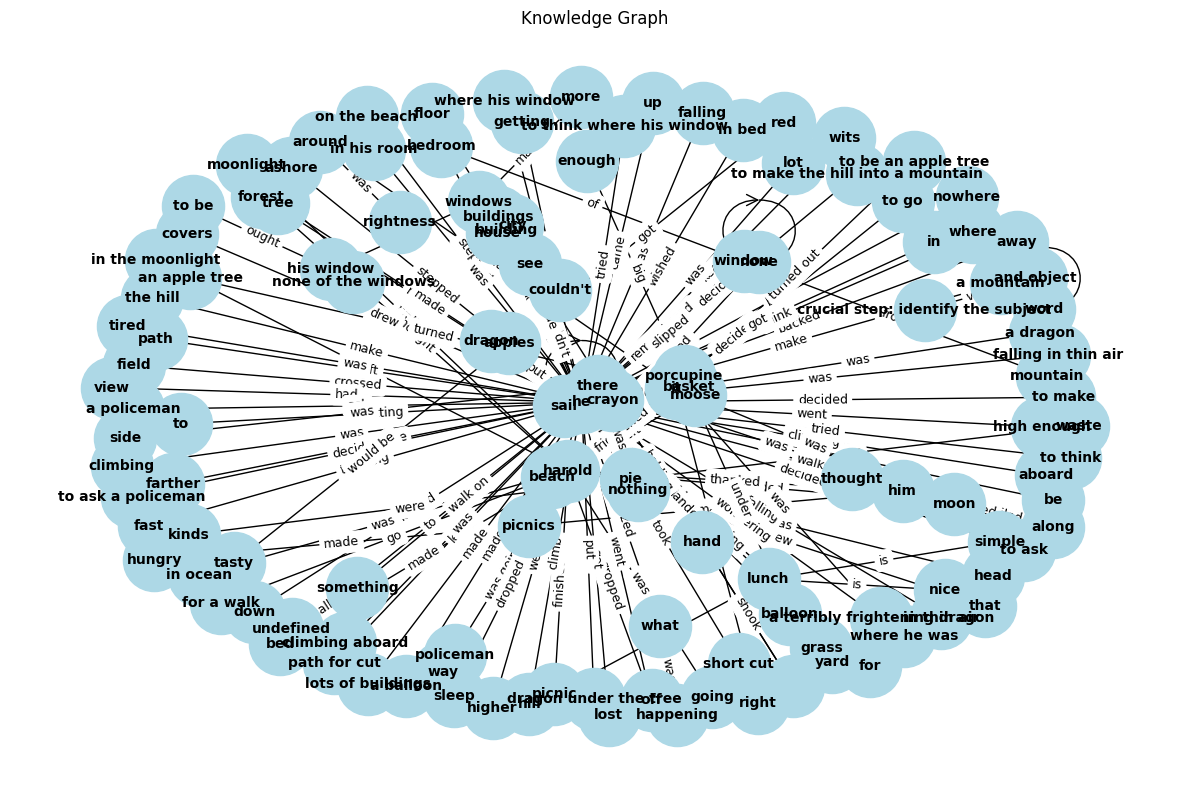

In [168]:
# Visualize knowledge graph of Harold and the Purple Crayon, tight layout. 

%matplotlib inline
import matplotlib.pyplot as plt
import networkx as nx

def visualize_knowledge_graph(graph, title="Knowledge Graph"):
    """
    Visualizes a directed knowledge graph with labeled edges.
    
    Parameters:
        graph (dict): A dictionary where each key is a subject and each value is a list of (subject, object, predicate) tuples.
        title (str): Title of the graph visualization.
    """
    G = nx.DiGraph()

    # Add edges with lowercase normalization
    for subj, edges_list in graph.items():
        subj_lower = subj.lower()
        for obj, pred in edges_list:
            obj_lower = obj.lower()
            pred_lower = pred.lower()
            G.add_edge(subj_lower, obj_lower, label=pred_lower)

    if G.number_of_edges() == 0:
        print("Graph is empty! No edges to draw.")
        return

    pos = nx.spring_layout(G, seed=42)

    plt.figure(figsize=(12, 8))
    nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=2000)
    nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=20)
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')

    edge_labels = nx.get_edge_attributes(G, 'label')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=9)

    plt.title(title)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig("KG_Book.png")
    plt.show()

visualize_knowledge_graph(graph)

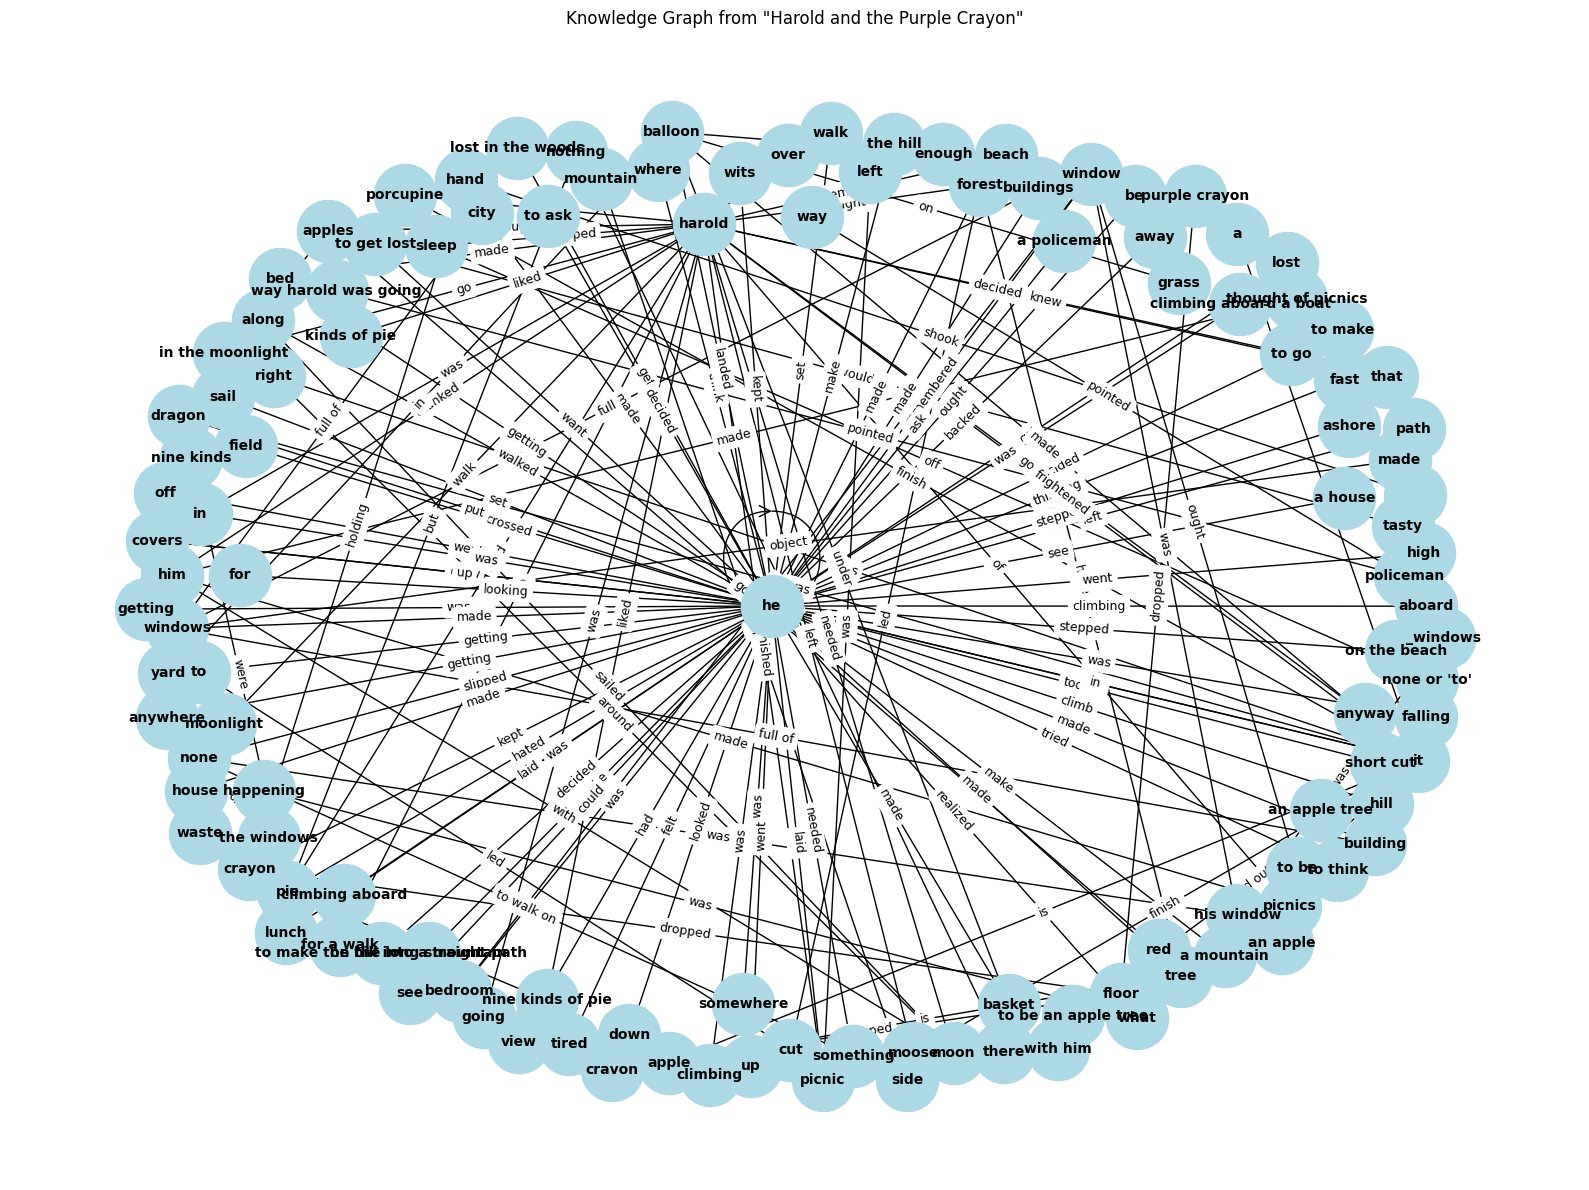

In [247]:
# Visualize knowledge graph of Harold and the Purple Crayon, loose layout. 

%matplotlib inline
import matplotlib.pyplot as plt
import networkx as nx

def visualize_knowledge_graph(graph, title):
    """
    Visualizes a directed knowledge graph with labeled edges.
    
    Parameters:
        graph (dict): A dictionary where each key is a subject and each value is a list of (subject, object, predicate) tuples.
        title (str): Title of the graph visualization.
    """
    G = nx.DiGraph()

    # Add edges with lowercase normalization
    for subj, edges_list in graph.items():
        subj_lower = subj.lower()
        for obj, pred in edges_list:
            obj_lower = obj.lower()
            pred_lower = pred.lower()
            G.add_edge(subj_lower, obj_lower, label=pred_lower)

    if G.number_of_edges() == 0:
        print("Graph is empty! No edges to draw.")
        return

    # Increase k for more space between nodes
    pos = nx.spring_layout(G, seed=42, k=2.0)

    plt.figure(figsize=(16, 12))
    nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=2000)
    nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=20)
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')

    edge_labels = nx.get_edge_attributes(G, 'label')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=9)

    plt.title(title)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig("KG_Book.png")
    plt.show()

visualize_knowledge_graph(graph, "Knowledge Graph from \"Harold and the Purple Crayon\"")


### Question-Answering

In [ ]:
# NOT RUN
# Single Hop DFS Test
# Match path and visualize information retrieval path within subgraph

import networkx as nx
import matplotlib.pyplot as plt

def dfs_until_match(graph, start, visited=None, path=None, edges=None):
    if visited is None:
        visited = set()
    if path is None:
        path = []
    if edges is None:
        edges = []

    visited.add(start)
    path = path + [start]  # avoid shared state

    time.sleep(3)

    response = ask_groq(f"{query} {start}")
    print(f"Checking node: {start} → Response: {response.strip().lower()}")

    if response.strip().lower() == 'yes':
        return path, edges, True  # return both path and edges

    for neighbor, relation in graph.get(start, []):
        if neighbor not in visited:
            new_edges = edges + [(start, relation, neighbor)]
            result_path, result_edges, found = dfs_until_match(
                graph, neighbor, visited, path, new_edges)
            if found:
                return result_path, result_edges, True
    return path, edges, False


def visualize_dfs_path(graph_dict, path, edges, title="DFS Traversal Visualization"):
    """
    Visualizes the traversal path and edges in a directed graph.

    Parameters:
        graph_dict (dict): The original graph structure as an adjacency list.
        path (list): The list of nodes visited in the order they were traversed.
        edges (list): The list of (subject, predicate, object) tuples in the traversal.
        title (str): Title of the plot.
    """
    G = nx.DiGraph()

    # Add all nodes and edges from the original graph for context (optional)
    for subj, relations in graph_dict.items():
        for obj, pred in relations:
            G.add_edge(subj, obj, label=pred)

    # Highlighted edges are the ones traversed
    edge_labels = {(s, o): p for s, p, o in edges}

    pos = nx.spring_layout(G, seed=42)

    plt.figure(figsize=(12, 8))
    nx.draw_networkx_nodes(G, pos, node_color='lightgray', node_size=800)
    nx.draw_networkx_edges(G, pos, edge_color='lightgray')

    # Draw only traversed path in bold
    nx.draw_networkx_edges(
        G,
        pos,
        edgelist=[(s, o) for s, _, o in edges],
        edge_color='blue',
        width=2
    )

    # Draw path nodes in a different color
    nx.draw_networkx_nodes(
        G,
        pos,
        nodelist=path,
        node_color='orange',
        node_size=1000
    )

    nx.draw_networkx_labels(G, pos, font_size=10, font_color='black')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=9)

    plt.title(title)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig("test.png")
    plt.show()

# visualize_dfs_path(graph, path, edges)

DFS from start.
Checking node: he → Response: no
Checking node: something → Response: no
Checking node: none → Response: no
Checking node: on → Response: no
Checking node: path → Response: no
Checking node: lost → Response: no
Checking node: walk → Response: no
Checking node: moonlight → Response: no
Checking node: crayon → Response: no
Checking node: floor → Response: no
Checking node: anywhere → Response: yes
DFS Path: he -> anywhere
Edges Traversed:
he -[seem]-> anywhere


In [302]:
# DFS Match and Subgraph Extraction (Multi-Hop)

import time

# The code is designed to search through a graph until it finds a node whose metadata is relevant to a question, 
# based on a response from the ask_groq() function.

# Once it finds a "matching" node (where the AI responds with "TRUE"), it collects the subgraph reachable 
# from that node and returns:
# the path taken to reach that node,
# all the edges traversed,
# and whether the goal was found.

# If it is still relevant, continue collecting 

def collect_reachable_subgraph(graph, node, visited=None, edges=None):
    if visited is None:
        visited = set()
    if edges is None:
        edges = []

    visited.add(node)
    for neighbor, relation in graph.get(node, []):
        if (node, relation, neighbor) not in edges:
            edges.append((node, relation, neighbor))
        if neighbor not in visited:
            collect_reachable_subgraph(graph, neighbor, visited, edges)

    return visited, edges

def dfs_until_match(graph, start, visited=None, path=None, edges=None):
    if visited is None:
        visited = set()
    if path is None:
        path = []
    if edges is None:
        edges = []

    visited.add(start)
    path = path + [start]  # avoid shared state

    time.sleep(3)

    response = ask_groq(f"{query} {start}")
    print(f"Checking node: {start} → Response: {response.strip().lower()}")

    if "true" in response.strip().lower():
        subgraph_nodes, subgraph_edges = collect_reachable_subgraph(graph, start)
        return list(subgraph_nodes), edges + subgraph_edges, True

    for neighbor, relation in graph.get(start, []):
        if neighbor not in visited:
            new_edges = edges + [(start, relation, neighbor)]
            result_path, result_edges, found = dfs_until_match(
                graph, neighbor, visited, path, new_edges)
            if found:
                return result_path, result_edges, True
            
    return path, edges, False

In [ ]:
# NOT RUN
# Endless search test
# Will search on the subgraph where edges are connected to the specified "start" node (in this case harold)
# Until reaching the condition is met (specified by query)

query = "Is the name anne? Reply just YES or NO. This is the name: "
start = "he"

print("DFS from start.")
path, edges, found = dfs_until_match(graph, start)

print("DFS Path:", " -> ".join(path))
print("Edges Traversed:")

for subj, pred, obj in edges:
    print(f"{subj} -[{pred}]-> {obj}")

In [ ]:
# Question about Harold's agency

#question = "Can you tell me about Harold's agency?"

question = "Can you tell me about Harold's agency? This text is about a singular character, so the pronouns 'he,' 'him,' and 'his' also refer to Harold."
query = f"""
Each of these nodes has associated metadata.
Do you think the information from this node's metadata might be a hint to answer this question: {question}?
Reply with TRUE if it is a hint, or FALSE if it is not a hint.
This is the node:
"""

# Start traversal
start = "he"
print("DFS from start.")
path, edges, found = dfs_until_match(graph, start)

print("\nDFS Path:", " -> ".join(path))
print("Edges Traversed:")
for subj, pred, obj in edges:
    print(f"{subj} -[{pred}]-> {obj}")

DFS from start.
Checking node: he → Response: true.

DFS Path:  -> ashore -> grass -> more -> a policeman -> it -> anywhere -> hungry -> aboard -> on the beach -> he ought to be getting to bed -> a house -> picnics -> an apple tree -> right -> apples -> pie -> down -> tired -> to be an apple tree -> up -> a mountain -> None -> high enough -> hill -> him -> bedroom -> wits -> that -> to be -> off -> climbing -> getting -> getting to bed -> city -> happening -> for -> moonlight -> to ask -> fast -> somewhere -> sail -> to make the hill into a mountain -> his window -> moon -> dragon -> building -> see -> away -> view -> a -> windows -> to be getting -> crayon -> along -> covers -> tasty -> he -> buildings -> to -> house -> to think where his window ought to be -> short cut -> mountain -> in -> the hill -> tree -> climbing aboard -> something -> anyway -> field -> waste -> with him -> a dragon -> basket -> where -> balloon -> harold -> boat -> window -> what -> forest -> falling -> yard -

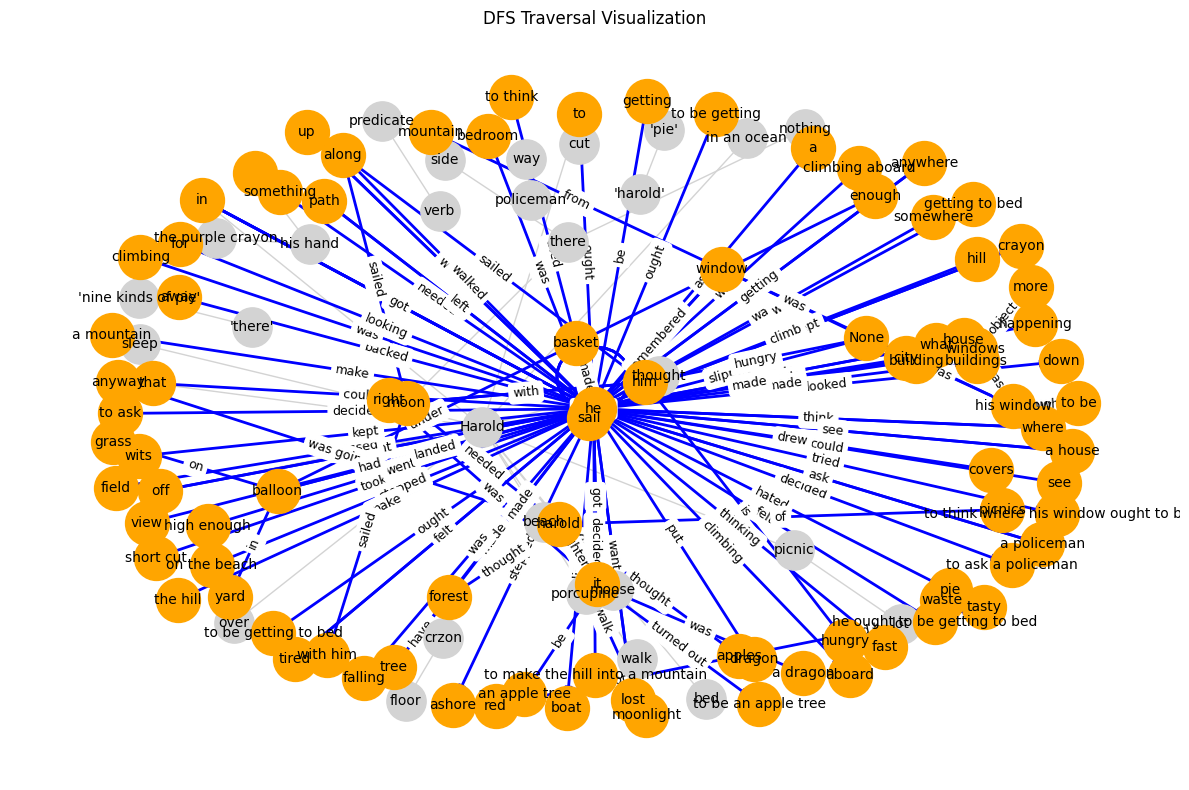

In [290]:
# NOT RUN 
# Visualize information retrieval path within subgraph

import networkx as nx
import matplotlib.pyplot as plt

def visualize_dfs_path(graph_dict, path, edges, title="DFS Traversal Visualization"):
    """
    Visualizes the traversal path and edges in a directed graph.

    Parameters:
        graph_dict (dict): The original graph structure as an adjacency list.
        path (list): The list of nodes visited in the order they were traversed.
        edges (list): The list of (subject, predicate, object) tuples in the traversal.
        title (str): Title of the plot.
    """
    G = nx.DiGraph()

    # Add all nodes and edges from the original graph for context (optional)
    for subj, relations in graph_dict.items():
        for obj, pred in relations:
            G.add_edge(subj, obj, label=pred)

    # Highlighted edges are the ones traversed
    edge_labels = {(s, o): p for s, p, o in edges}

    pos = nx.spring_layout(G, seed=42)

    plt.figure(figsize=(12, 8))
    nx.draw_networkx_nodes(G, pos, node_color='lightgray', node_size=800)
    nx.draw_networkx_edges(G, pos, edge_color='lightgray')

    # Draw only traversed path in bold
    nx.draw_networkx_edges(
        G,
        pos,
        edgelist=[(s, o) for s, _, o in edges],
        edge_color='blue',
        width=2
    )

    # Draw path nodes in a different color
    nx.draw_networkx_nodes(
        G,
        pos,
        nodelist=path,
        node_color='orange',
        node_size=1000
    )

    nx.draw_networkx_labels(G, pos, font_size=10, font_color='black')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=9)

    plt.title(title)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig("test.png")
    plt.show()

visualize_dfs_path(graph, path, edges)

In [304]:
# Define your query and starting point
question = "What keywords should I use to analyze word co-occurrence in 'Harold and the Purple Crayon' using text mining? Reply with just the keywords."
query = f"""
Each of these nodes has associated metadata.
Do you think the information from this node's metadata might be a hint to answer this question: {question}?
Reply with TRUE if it is a hint, or FALSE if it is not a hint.
This is the node:
"""

query = f"""
Each of these nodes has associated metadata.
Do you think the information from this node's metadata might be a hint to answer this question: {question}?
Reply with HINT if it is a hint, or NOT HINT if it is not a hint.
This is the node:
"""


# Start traversal
start = "he"
print("DFS from start.")
path, edges, found = dfs_until_match(graph, start)

print("\nDFS Path:", " -> ".join(path))
print("Edges Traversed:")
for subj, pred, obj in edges:
    print(f"{subj} -[{pred}]-> {obj}")

DFS from start.
Checking node: he → Response: not hint
Checking node: something → Response: not hint
Checking node:  → Response: not hint
Checking node: path → Response: not hint
Checking node: lost → Response: not hint
Checking node: walk → Response: not hint
Checking node: moonlight → Response: hint
Checking node: crayon → Response: hint
Checking node: none → Response: not hint
Checking node: anywhere → Response: not hint
Checking node: getting → Response: not hint
Checking node: path for a short cut → Response: not hint
Checking node: short cut → Response: not hint
Checking node: forest → Response: hint
Checking node: field → Response: not hint
Checking node: to get lost → Response: hint
Checking node: lost in the woods → Response: hint
Checking node: tree → Response: not hint
Checking node: dragon → Response: not hint
Checking node: apples → Response: not hint
Checking node: tasty → Response: not hint
Checking node: red → Response: not hint
Checking node: frightening → Response: no

### Create and Visualize Subgraphs

In [ ]:
# NOT RUN 
# See which sentences contain a keyword

import re

# Compile regex patterns for exact word matches
#pattern_he = re.compile(r'\bhe\b', re.IGNORECASE)
pattern_harold = re.compile(r'\bharold\b', re.IGNORECASE)

# Filter sentences
#filtered_sentences = [s for s in text if pattern_he.search(s) or pattern_harold.search(s)]

filtered_sentences = [s for s in text if pattern_harold.search(s)]

One evening, after thiniking it over for some time, Harold decided to go for a walk in the moonlight.
There wasn't any moon and Harold needed a moon for a walk in the moonlight.
The short cut led right to were Harold thought a forest ought to be.
The apples would be very tasty, Harold thought, when they got red.
It even frightened Harold.
But by then Harold was over his head in an ocean.
The sandy beach reminded Harold of picnics.
But there were all nine kinds of pie that Harold liked best.
When Harold finished his picnic there was quite a lot left.
So Harold left a very hungry moose and a deserving porcupine to finish it up.
Harold knew thaht the higher up he went, the farthter he could see.
The policeman pointed the way Harold was going anyway.
But Harold thanked him.
Then, suddenly, Harold remembered.
And then Harold made his bed.
And Harold dropped off to sleep.


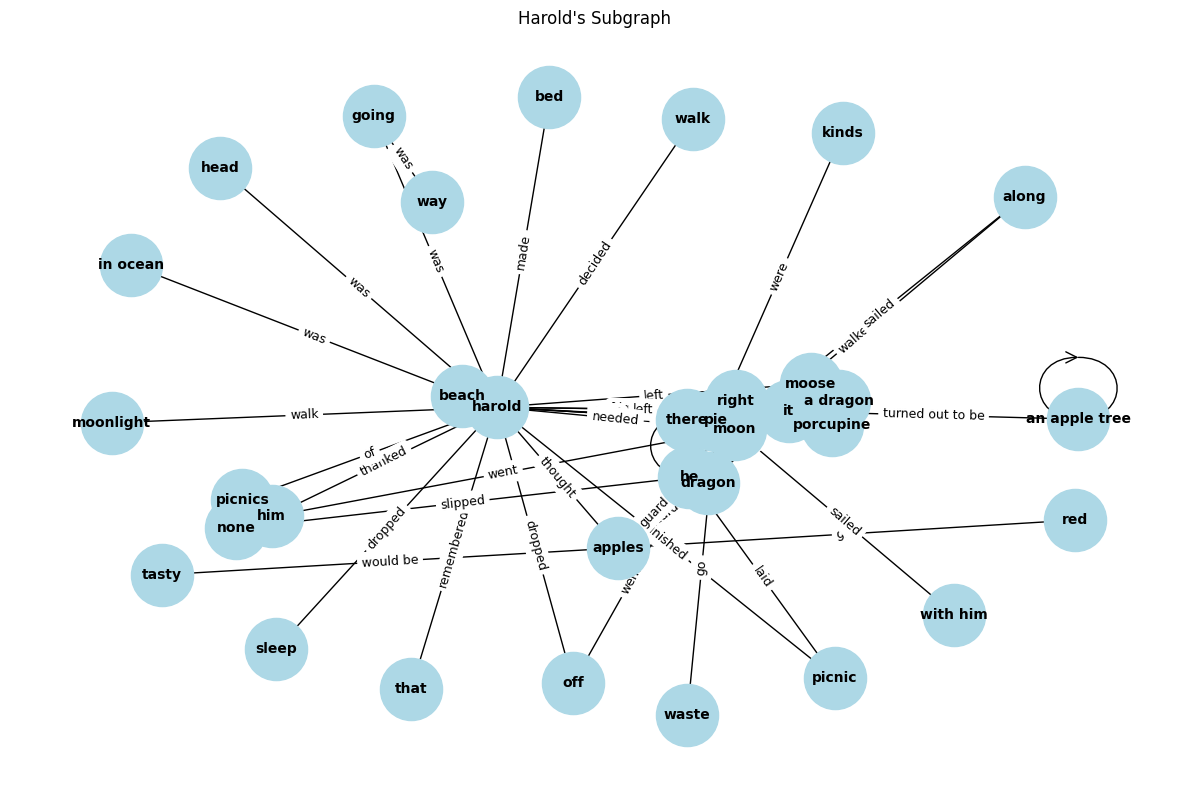

In [134]:
%matplotlib inline
import matplotlib.pyplot as plt
import networkx as nx

def get_harold_subgraph(graph):
    G_full = nx.DiGraph()

    # Normalize and build full graph
    for subj, edges_list in graph.items():
        subj_lower = subj.lower()
        for obj, pred in edges_list:
            obj_lower = obj.lower()
            pred_lower = pred.lower()
            G_full.add_edge(subj_lower, obj_lower, label=pred_lower)

    # Find first and second-degree neighbors of 'harold'
    harold = 'harold'
    if harold not in G_full:
        print("No node named 'harold' found in the graph.")
        return nx.DiGraph()  # empty graph

    first_neighbors = set(G_full.successors(harold)).union(set(G_full.predecessors(harold)))
    second_neighbors = set()
    for node in first_neighbors:
        second_neighbors.update(G_full.successors(node))
        second_neighbors.update(G_full.predecessors(node))

    nodes_to_include = {harold} | first_neighbors | second_neighbors
    subgraph = G_full.subgraph(nodes_to_include).copy()
    return subgraph

def visualize_knowledge_graph(graph, title, png_name):
    if graph.number_of_edges() == 0:
        print("Graph is empty! No edges to draw.")
        return

    pos = nx.spring_layout(graph, seed=42)

    plt.figure(figsize=(12, 8))
    nx.draw_networkx_nodes(graph, pos, node_color='lightblue', node_size=2000)
    nx.draw_networkx_edges(graph, pos, arrowstyle='->', arrowsize=20)
    nx.draw_networkx_labels(graph, pos, font_size=10, font_weight='bold')

    edge_labels = nx.get_edge_attributes(graph, 'label')
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels, font_size=9)

    plt.title(title)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(png_name)
    plt.show()

harold_subgraph = get_harold_subgraph(graph)
visualize_knowledge_graph(harold_subgraph, title="Harold's Subgraph", png_name="harold_subgraph.png")


moose
moose
moose
moose
Failed with status code 429: {"error":{"message":"Rate limit reached for model `llama-3.3-70b-versatile` in organization `org_01hqxgf45sfcm9p5vmwhwnskj3` service tier `on_demand` on tokens per day (TPD): Limit 100000, Used 99959, Requested 66. Please try again in 21.416999999s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing","type":"tokens","code":"rate_limit_exceeded"}}

Failed with status code 429: {"error":{"message":"Rate limit reached for model `llama-3.3-70b-versatile` in organization `org_01hqxgf45sfcm9p5vmwhwnskj3` service tier `on_demand` on tokens per day (TPD): Limit 100000, Used 99959, Requested 66. Please try again in 21.224s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing","type":"tokens","code":"rate_limit_exceeded"}}

Failed with status code 429: {"error":{"message":"Rate limit reached for model `llama-3.3-70b-versatile` in organization `org_01hqxgf45sfcm9p5vmwhwn

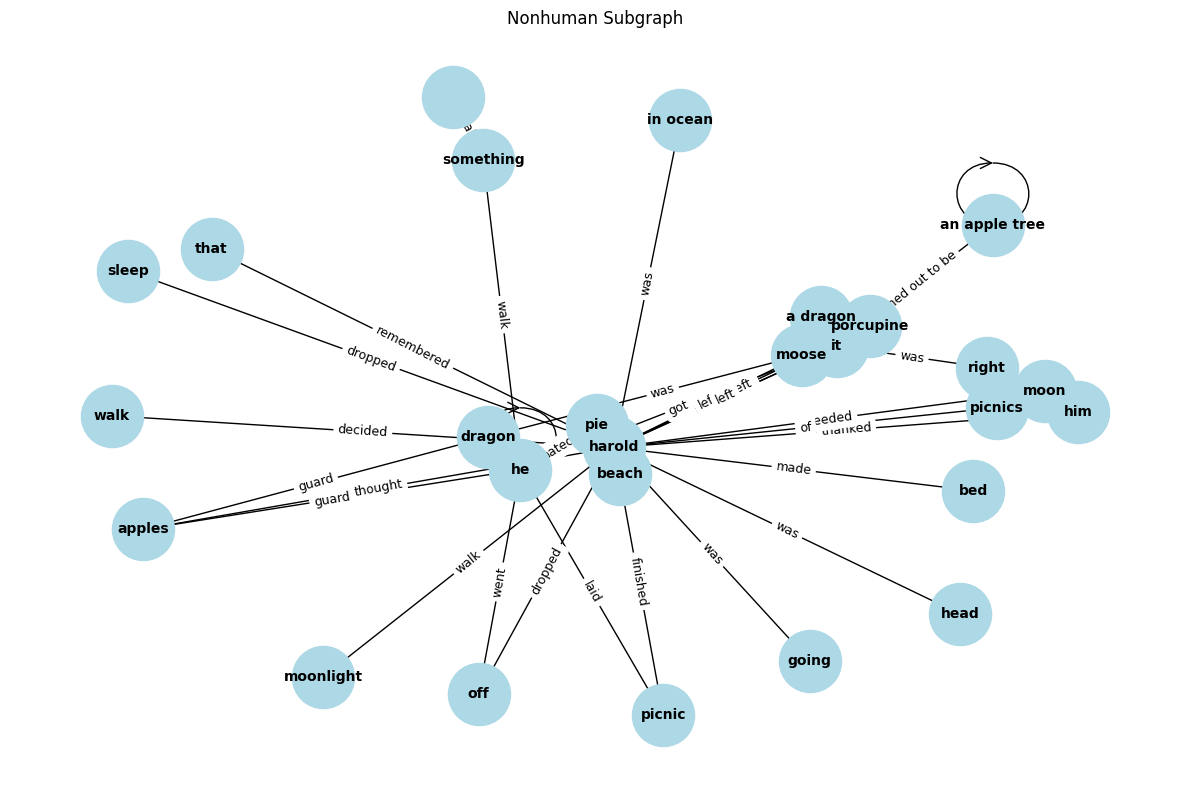

In [147]:
%matplotlib inline
import matplotlib.pyplot as plt
import networkx as nx

def get_nonhuman_subgraph(graph, start):
    import networkx as nx

    G_full = nx.DiGraph()

    # Normalize and build full graph
    for subj, edges_list in graph.items():
        subj_lower = subj.lower()
        for obj, pred in edges_list:
            obj_lower = obj.lower()
            pred_lower = pred.lower()
            G_full.add_edge(subj_lower, obj_lower, label=pred_lower)

    for key in graph:
        # Use ask_groq to determine if the sentence should be kept
        # # Does this sentence contain a non-human creature?
        response = ask_groq(f"""
                            Is this word a nonhuman creature? 
                            If so, return just the word.
                            If it does not, return an empty string. 
                            Here is the sentence: {start}""")
        print(response)
    

    if not response.strip():
        print("Sentence does not contain a non-human creature. Filtering out.")
        return nx.DiGraph()  # return empty graph

    # Proceed with subgraph construction for all entities in the sentence
    nodes_in_sentence = {node for node in G_full.nodes if node in start.lower()}
    if not nodes_in_sentence:
        print("No matching nodes found in the graph for this sentence.")
        return nx.DiGraph()  # empty graph

    # Build neighborhood around the nodes in the sentence
    first_neighbors = set()
    for node in nodes_in_sentence:
        first_neighbors.update(G_full.successors(node))
        first_neighbors.update(G_full.predecessors(node))

    second_neighbors = set()
    for node in first_neighbors:
        second_neighbors.update(G_full.successors(node))
        second_neighbors.update(G_full.predecessors(node))

    nodes_to_include = nodes_in_sentence | first_neighbors | second_neighbors
    subgraph = G_full.subgraph(nodes_to_include).copy()
    return subgraph

nonhuman_subgraph = get_nonhuman_subgraph(graph, "moose")
visualize_knowledge_graph(nonhuman_subgraph, "Nonhuman Subgraph", "nonhuman_subgraph.png")

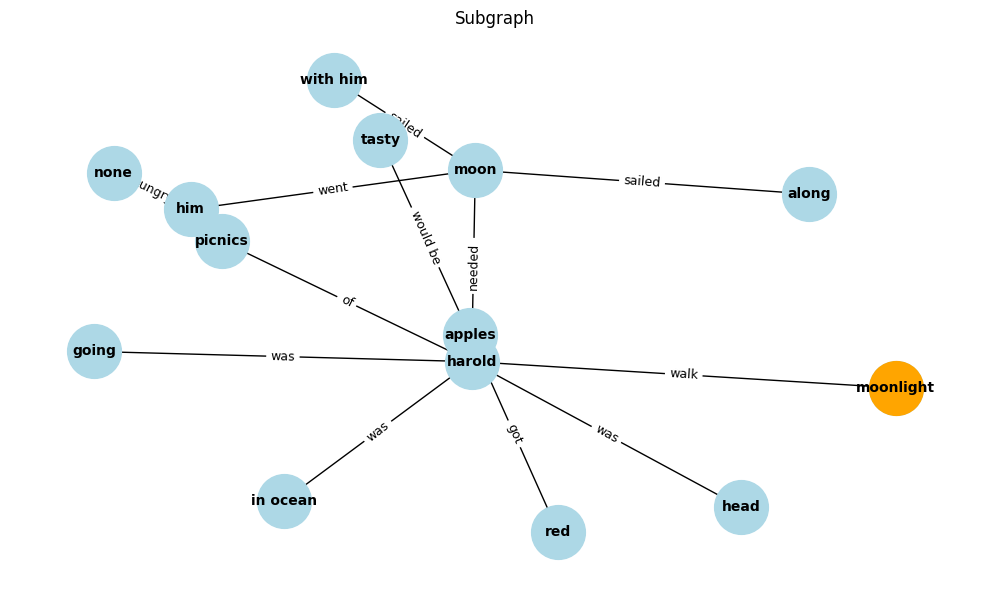

In [140]:
%matplotlib inline
import matplotlib.pyplot as plt
import networkx as nx

def visualize_subgraph(path, edges, title="DFS Subgraph Traversal"):
    """
    Visualize a subgraph consisting of the nodes visited and edges traversed in DFS.
    
    Parameters:
        path (list): List of nodes visited during DFS.
        edges (list of tuples): List of (subject, predicate, object) triples traversed.
        title (str): Title of the graph visualization.
    """
    if not path or not edges:
        print("Nothing to visualize: empty path or edges.")
        return

    G = nx.DiGraph()

    # Add edges and nodes
    for subj, pred, obj in edges:
        G.add_edge(subj.lower(), obj.lower(), label=pred.lower())

    pos = nx.spring_layout(G, seed=42)

    plt.figure(figsize=(10, 6))
    nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=1500)
    nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=20)
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')

    edge_labels = nx.get_edge_attributes(G, 'label')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=9)

    # Highlight final matched node
    nx.draw_networkx_nodes(G, pos, nodelist=[path[-1].lower()], node_color='orange', node_size=1500)

    plt.title(title)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

visualize_subgraph(path, edges, title="Subgraph")

### View Node Metadata

In [291]:
def extract_triples(sentence):
    """
    Convert ask_groq's string output to a list of (subject, predicate, object) tuples.
    """
    groq_output = ask_groq(f"""
        Return just the subject, verb, object 
        and object, predicate, object triples from this sentence:  
        {sentence}
        Return the output like this (word, word, word)
    """)
    
    # Use regex to find all patterns like (word, word, word)
    triple_pattern = re.findall(r'\(([^)]+)\)', groq_output)
    
    triples = []
    for triple in triple_pattern:
        parts = [part.strip() for part in triple.split(',')]
        if len(parts) == 3:
            triples.append((parts[0], parts[1], parts[2]))
    return triples

def build_knowledge_graph(triples, sentences):
    """
    Build a directed graph where each node is a dictionary with a 'text' key storing associated sentences.
    """
    graph = defaultdict(list)
    node_data = defaultdict(set)  # Map entity to set of sentences

    for sentence in sentences:
        sentence = sentence.lower()
        sentence_triples = extract_triples(sentence)
        for subj, pred, obj in sentence_triples:
            graph[subj].append((obj, pred))
            node_data[subj].add(sentence)
            node_data[obj].add(sentence)

    # Convert sets to plain dicts with text list
    node_metadata = {k: {'text': list(v)} for k, v in node_data.items()}
    return graph, node_metadata

def dfs_until_match(graph, node_metadata, start, query, visited=None, path=None, edges=None):
    if visited is None:
        visited = set()
    if path is None:
        path = []
    if edges is None:
        edges = []

    visited.add(start)
    path = path + [start]  # Avoid mutability issues

    time.sleep(3)

    response = ask_groq(f"{query} {start}")

    #print(f"Visited: {visited}")
    print(f"Response: {response}")

    #print(f"Checking node: {start} → Response: {response.strip().lower()}")

    if response.strip().lower() == 'yes':
        return path, edges, True

    for neighbor, relation in graph.get(start, []):
        if neighbor not in visited:
            new_edges = edges + [(start, relation, neighbor)]
            result_path, result_edges, found = dfs_until_match(
                graph, node_metadata, neighbor, query, visited, path, new_edges
            )
            if found:
                return result_path, result_edges, True
    return path, edges, False

all_sentences = [s.lower() for s in text]

graph, node_metadata = build_knowledge_graph([], all_sentences)

#print("Knowledge Graph:")
#for subj in graph:
#    for obj, pred in graph[subj]:
#        print(f"{subj} -[{pred}]-> {obj}")

#question = "What keywords should I use to analyze word co-occurrence in 'Harold and the Purple Crayon' using text mining? Reply with just the keywords."
#query = f"""
#Each of these nodes has associated metadata.
#Do you think the information from this node's metadata might be a hint to answer this question: {question}?
#Reply with YES if it is a hint, or NO if it is not a hint.
#This is the node:
#"""

path, edges, found = dfs_until_match(graph, node_metadata, "he", query)

#print("\nDFS Path:", " -> ".join(path))
#print("Edges Traversed:")
#for subj, pred, obj in edges:
#    print(f"{subj} -[{pred}]-> {obj}")

#print("\nNode Metadata (Context Sentences):")
#for node, meta in node_metadata.items():
#    print(f"{node}: {meta['text']}")

Response: Failed with status code 429: {"error":{"message":"Rate limit reached for model `llama-3.3-70b-versatile` in organization `org_01hqxgf45sfcm9p5vmwhwnskj3` service tier `on_demand` on tokens per day (TPD): Limit 100000, Used 100039, Requested 97. Please try again in 1m58.114s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing","type":"tokens","code":"rate_limit_exceeded"}}

Response: Failed with status code 429: {"error":{"message":"Rate limit reached for model `llama-3.3-70b-versatile` in organization `org_01hqxgf45sfcm9p5vmwhwnskj3` service tier `on_demand` on tokens per day (TPD): Limit 100000, Used 100036, Requested 98. Please try again in 1m55.782s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing","type":"tokens","code":"rate_limit_exceeded"}}



KeyboardInterrupt: 

In [236]:
import re
import time
from collections import defaultdict

def extract_triples(sentence):
    """
    Convert ask_groq's string output to a list of (subject, predicate, object) tuples.
    """
    groq_output = ask_groq(f"""
        Return just the subject, verb, object 
        and object, predicate, object triples from this sentence:  
        {sentence}
        Return the output like this (word, word, word)
    """)
    
    triple_pattern = re.findall(r'\(([^)]+)\)', groq_output)
    triples = []
    for triple in triple_pattern:
        parts = [part.strip() for part in triple.split(',')]
        if len(parts) == 3:
            triples.append((parts[0].lower(), parts[1].lower(), parts[2].lower()))
    return triples

def build_knowledge_graph(sentences):
    """
    Build a directed graph with metadata, where nodes are words and edges are predicates.
    """
    graph = defaultdict(list)
    node_data = defaultdict(set)

    for sentence in sentences:
        sentence = sentence.lower()
        triples = extract_triples(sentence)
        for subj, pred, obj in triples:
            graph[subj].append((obj, pred))
            node_data[subj].add(sentence)
            node_data[obj].add(sentence)

    node_metadata = {k: {'text': list(v)} for k, v in node_data.items()}
    return graph, node_metadata

def dfs_until_match(graph, node_metadata, start, query, visited=None, path=None, edges=None):
    if visited is None:
        visited = set()
    if path is None:
        path = []
    if edges is None:
        edges = []

    visited.add(start)
    path = path + [start]

    time.sleep(4)


    # Use associated metadata (text) in the query
    metadata_text = " ".join(node_metadata.get(start, {}).get('text', []))
    response = ask_groq(f"""
    {query}
    NODE: {start}
    CONTEXT: {metadata_text}
    """)

    print("Metadata text:")
    print(metadata_text)

    print(f"Checking node: {start} → Response: {response.strip().lower()}")

    if response.strip().lower() == 'yes':
        return path, edges, True

    for neighbor, relation in graph.get(start, []):
        if neighbor not in visited:
            new_edges = edges + [(start, relation, neighbor)]
            result_path, result_edges, found = dfs_until_match(
                graph, node_metadata, neighbor, query, visited, path, new_edges
            )
            if found:
                return result_path, result_edges, True

    return path, edges, False

# Lowercased input text
all_sentences = [s.lower() for s in text]

# Build the graph using extracted triples
graph, node_metadata = build_knowledge_graph(all_sentences)

# Define your question and the evaluation query
question = "What keywords should I use to analyze word co-occurrence in 'Harold and the Purple Crayon' using text mining? Reply with just the keywords."
query = f"""
Each of these nodes has associated metadata from the original text.
Do you think this node’s metadata might help answer this question: {question}?
Reply with YES if it is a hint, or NO if it is not a hint.
"""

# Run the graph search starting from a keyword
start_node = "harold"
path, edges, found = dfs_until_match(graph, node_metadata, start_node, query)

if found:
    print("Found relevant node!")
    print("Path:", path)
    print("Edges:", edges)
else:
    print("No relevant node found.")


Metadata text:
there wasn't any moon and harold needed a moon for a walk in the moonlight. one evening, after thinking it over for some time, harold decided to go for a walk in the moonlight.
Checking node: harold → Response: failed with status code 429: {"error":{"message":"rate limit reached for model `llama-3.3-70b-versatile` in organization `org_01hqxgf45sfcm9p5vmwhwnskj3` service tier `on_demand` on tokens per day (tpd): limit 100000, used 100006, requested 143. please try again in 2m8.844s. need more tokens? upgrade to dev tier today at https://console.groq.com/settings/billing","type":"tokens","code":"rate_limit_exceeded"}}
Metadata text:
there wasn't any moon and harold needed a moon for a walk in the moonlight. and he set off on his walk, taking his big purple crayon with him. one evening, after thinking it over for some time, harold decided to go for a walk in the moonlight.
Checking node: walk → Response: failed with status code 429: {"error":{"message":"rate limit reached f

KeyboardInterrupt: 

In [ ]:
node = "he"
if node in node_metadata:
    print(f"\nMetadata for {node}:")
    for sentence in node_metadata[node]["text"]:
        print(f"  - {sentence}")
else:
    print(f"No metadata found for {node}")


Metadata for he:
  - he made some more windows.


### Question-Answering

In [ ]:
context_from_search = """ 
One evening, after thiniking it over for some time, Harold decided to go for a walk in the moonlight.
There wasn't any moon and Harold needed a moon for a walk in the moonlight.
And he needed something to walk on.
He made a long straight path so he wouldn't get lost.
And he set off on his walk, taking his big purple crayon with him.
But he didn't seem to be getting wnywhere on the long straight path.
So he left the path for a short cut across a field.
The short cut led right to were Harold thought a forest ought to be.
He didn't want to get lost in the woods.
So he made a very small forest, with just one tree in it.
The apples would be very tasty, Harold thought, when they got red.
So he put a frightening dragon under the tree to gaurd the apples.
It even frightened Harold.
He backed away.
Suddenly he realized what was happening.
But by then Harold was over his head in an ocean.
He came up thinking fast.
And in no time he was climbing aboard a trim little boat.
He quickly set sail.
He stepped ashore on the beach, wondering where he was.
The sandy beach reminded Harold of picnics.
So he laid out a nice simple picnic lunch.
But there were all nine kinds of pie that Harold liked best.
When Harold finished his picnic there was quite a lot left.
He hated to see such delicious pie go to waste.
"""

In [ ]:
sentences_with_just_harold = f"""
One evening, after thinking it over for some time, Harold decided to go for a walk in the moonlight.
There wasn't any moon and Harold needed a moon for a walk in the moonlight.
The short cut led right to were Harold thought a forest ought to be.
"The apples would be very tasty, Harold thought, when they got red.
It even frightened Harold.
But by then Harold was over his head in an ocean.
The sandy beach reminded Harold of picnics.
But there were all nine kinds of pie that Harold liked best.
When Harold finished his picnic there was quite a lot left.
So Harold left a very hungry moose and a deserving porcupine to finish it up.
Harold knew that the higher up he went, the farther he could see.
The policeman pointed the way Harold was going anyway.
But Harold thanked him.
Then, suddenly, Harold remembered.
And then Harold made his bed.
And Harold dropped off to sleep.
"""

In [ ]:
q = f"""
What keywords should I use to analyze word co-occurrence in Harold and the Purple Crayon using text mining?
Reply with just the keywords.
Consider this context: {context_from_search}
"""

In [ ]:
q = f"""
Can you tell me about Harold's agency? Consider this context: {sentences_with_just_harold}
"""

ask_groq(q)

'Failed with status code 429: {"error":{"message":"Rate limit reached for model `llama-3.3-70b-versatile` in organization `org_01hqxgf45sfcm9p5vmwhwnskj3` service tier `on_demand` on tokens per day (TPD): Limit 100000, Used 99885, Requested 240. Please try again in 1m47.347s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing","type":"tokens","code":"rate_limit_exceeded"}}\n'

In [71]:
from pprint import pprint

pprint(node_metadata, sort_dicts=False)

{'Harold': {'text': ['one evening, after thiniking it over for some time, '
                     'harold decided to go for a walk in the moonlight.',
                     'when harold finished his picnic there was quite a lot '
                     'left.',
                     'the apples would be very tasty, harold thought, when '
                     'they got red.']},
 'walk': {'text': ['one evening, after thiniking it over for some time, harold '
                   'decided to go for a walk in the moonlight.',
                   'and he set off on his walk, taking his big purple crayon '
                   'with him.',
                   "there wasn't any moon and harold needed a moon for a walk "
                   'in the moonlight.']},
 'moonlight': {'text': ['one evening, after thiniking it over for some time, '
                        'harold decided to go for a walk in the moonlight.',
                        "there wasn't any moon and harold needed a moon for a "
          

In [6]:
import re

def filter_sentences(text_list):
    return [s for s in text_list if re.search(r'\b(he|harold)\b', s, re.IGNORECASE)]

filtered = filter_sentences(text)
for sentence in filtered:
    print(sentence)

One evening, after thinking it over for some time, Harold decided to go for a walk in the moonlight.
There wasn't any moon and Harold needed a moon for a walk in the moonlight.
And he needed something to walk on.
He made a long straight path so he wouldn't get lost.
And he set off on his walk, taking his big purple crayon with him.
But he didn't seem to be getting anywhere on the long straight path.
So he left the path for a short cut across a field.
The short cut led right to were Harold thought a forest ought to be.
He didn't want to get lost in the woods.
So he made a very small forest, with just one tree in it.
The apples would be very tasty, Harold thought, when they got red.
So he put a frightening dragon under the tree to gaurd the apples.
It even frightened Harold.
He backed away.
Suddenly he realized what was happening.
But by then Harold was over his head in an ocean.
He came up thinking fast.
And in no time he was climbing aboard a trim little boat.
He quickly set sail.
He s

In [ ]:
ask_groq(f"""
Can you provide an analysis of Harold’s agency that takes into account the full arc of his journey, describing both the moments when he demonstrates an ability to impact his world, as well as times where his sense of agency appears diminished? Tell me in 200 words or less. Keep in mind the pronoun ‘he’ also refers to Harold.
One evening, after thinking it over for some time, Harold decided to go for a walk in the moonlight.
There wasn't any moon and Harold needed a moon for a walk in the moonlight.
And he needed something to walk on.
He made a long straight path so he wouldn't get lost.
And he set off on his walk, taking his big purple crayon with him.
But he didn't seem to be getting anywhere on the long straight path.
So he left the path for a short cut across a field.
The short cut led right to were Harold thought a forest ought to be.
He didn't want to get lost in the woods.
So he made a very small forest, with just one tree in it.
The apples would be very tasty, Harold thought, when they got red.
So he put a frightening dragon under the tree to gaurd the apples.
It even frightened Harold.
He backed away.
Suddenly he realized what was happening.
But by then Harold was over his head in an ocean.
He came up thinking fast.
And in no time he was climbing aboard a trim little boat.
He quickly set sail.
He stepped ashore on the beach, wondering where he was.
The sandy beach reminded Harold of picnics.
So he laid out a nice simple picnic lunch.
But there were all nine kinds of pie that Harold liked best.
When Harold finished his picnic there was quite a lot left.
He hated to see such delicious pie go to waste.
So Harold left a very hungry moose and a deserving porcupine to finish it up.
And, off he went, looking for a hill to climb, to see where he was.
Harold knew thaht the higher up he went, the farther he could see.
So he decided to make the hill into a mountain.
If he went high enough, he thought, he could see the window of his bedroom.
He was tired and he felt he ought to be getting to bed.
He hoped he could see his bedroom window from the top of the mountain.
But as he looked down over the other side he slipped-
He was falling, in thin air.
But, luckily, he kept his wits and his purple crayon.
He made a balloon and he grabbed onto it.
And he made a basket under the balloon big enough to stand in.
He had a fine view from the balloon but he couldn't see his window.
He couldn't even see a house.
So he made a house, with windows.
And he landed the balloon on the grass in the front yard.
He tried to think where his window ought to be.
He made some more windows.
He made a big building full of windows.
He made lots of buildings full of windows.
He made a whole city full of windows.
He couldn't think where it might be.
He decided to ask a policeman.
The policeman pointed the way Harold was going anyway.
But Harold thanked him.
And he walked along with the moon, wishing he was in his room and in bed.
Then, suddenly, Harold remembered.
He remembered where his bedroom window was, when there was a moon.
And then Harold made his bed.
He got in it and he drew up the covers.
And Harold dropped off to sleep.

""")



"Harold's agency is evident throughout his journey as he utilizes his creativity and purple crayon to shape his world. He demonstrates control by creating a path, forest, dragon, boat, and mountain, showcasing his ability to impact his environment. However, his agency appears diminished when he becomes overwhelmed, such as when he encounters the frightening dragon or falls through thin air. In these moments, Harold's sense of control wavers, and he must rely on his wits and crayon to regain agency. Ultimately, Harold's agency is reestablished as he creates a city and finds his way back to his bedroom, highlighting his capacity for self-directed action and problem-solving."

: 

### Example Knowledge Ontologies

C:\Users\steph\AppData\Local\Temp\ipykernel_33256\3276990786.py:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


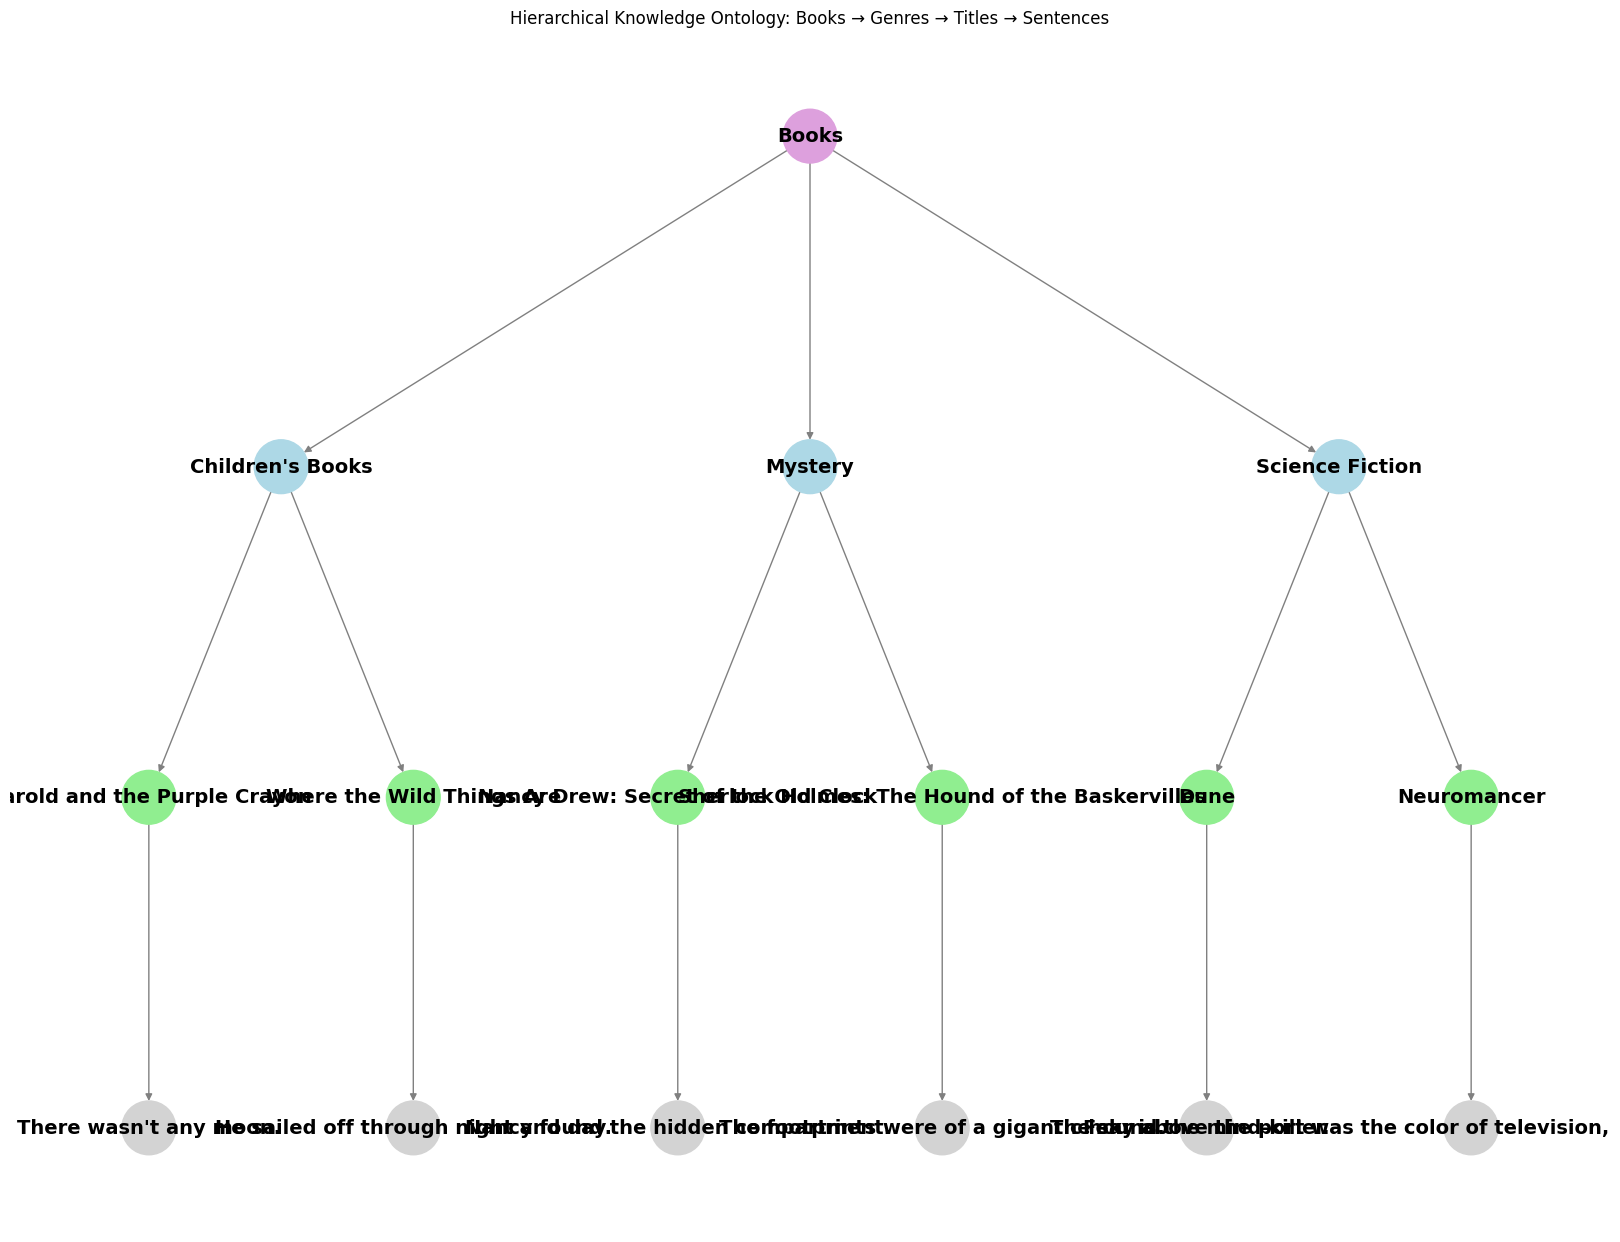

In [34]:
import networkx as nx
import matplotlib.pyplot as plt

# Create the graph
G = nx.DiGraph()

# Root node
G.add_node("Books", type="root")

# Genres
genres = ["Children's Books", "Mystery", "Science Fiction"]
for genre in genres:
    G.add_node(genre, type="genre")
    G.add_edge("Books", genre)

# Titles and sentences per genre
titles = {
    "Children's Books": [
        ("Harold and the Purple Crayon", "There wasn't any moon."),
        ("Where the Wild Things Are", "He sailed off through night and day."),
    ],
    "Mystery": [
        ("Nancy Drew: Secret of the Old Clock", "Nancy found the hidden compartment."),
        ("Sherlock Holmes: The Hound of the Baskervilles", "The footprints were of a gigantic hound."),
    ],
    "Science Fiction": [
        ("Dune", "Fear is the mind-killer."),
        ("Neuromancer", "The sky above the port was the color of television, tuned to a dead channel."),
    ]
}

# Manually assign x, y coordinates for hierarchy
pos = {
    "Books": (0, 9),
    "Children's Books": (-6, 7),
    "Mystery": (0, 7),
    "Science Fiction": (6, 7),
}

# Horizontal offsets per genre
x_offsets = {
    "Children's Books": [-7.5, -4.5],
    "Mystery": [-1.5, 1.5],
    "Science Fiction": [4.5, 7.5]
}

# Add titles and sentences
for genre, entries in titles.items():
    for i, (title, sentence) in enumerate(entries):
        x_title = x_offsets[genre][i]
        x_sentence = x_title
        y_title = 5
        y_sentence = 3

        G.add_node(title, type="title")
        G.add_node(sentence, type="sentence")

        G.add_edge(genre, title)
        G.add_edge(title, sentence)

        pos[title] = (x_title, y_title)
        pos[sentence] = (x_sentence, y_sentence)

# Colors by type
node_colors = [
    'plum' if G.nodes[n]['type'] == 'root'
    else 'lightblue' if G.nodes[n]['type'] == 'genre'
    else 'lightgreen' if G.nodes[n]['type'] == 'title'
    else 'lightgray'
    for n in G.nodes
]

# Draw the graph
plt.figure(figsize=(16, 12))
nx.draw(G, pos, with_labels=True, arrows=True,
        node_color=node_colors, node_size=1500,
        font_size=14, font_weight='bold', edge_color='gray')

plt.title("Hierarchical Knowledge Ontology: Books → Genres → Titles → Sentences")
plt.axis('off')
plt.tight_layout()
plt.show()


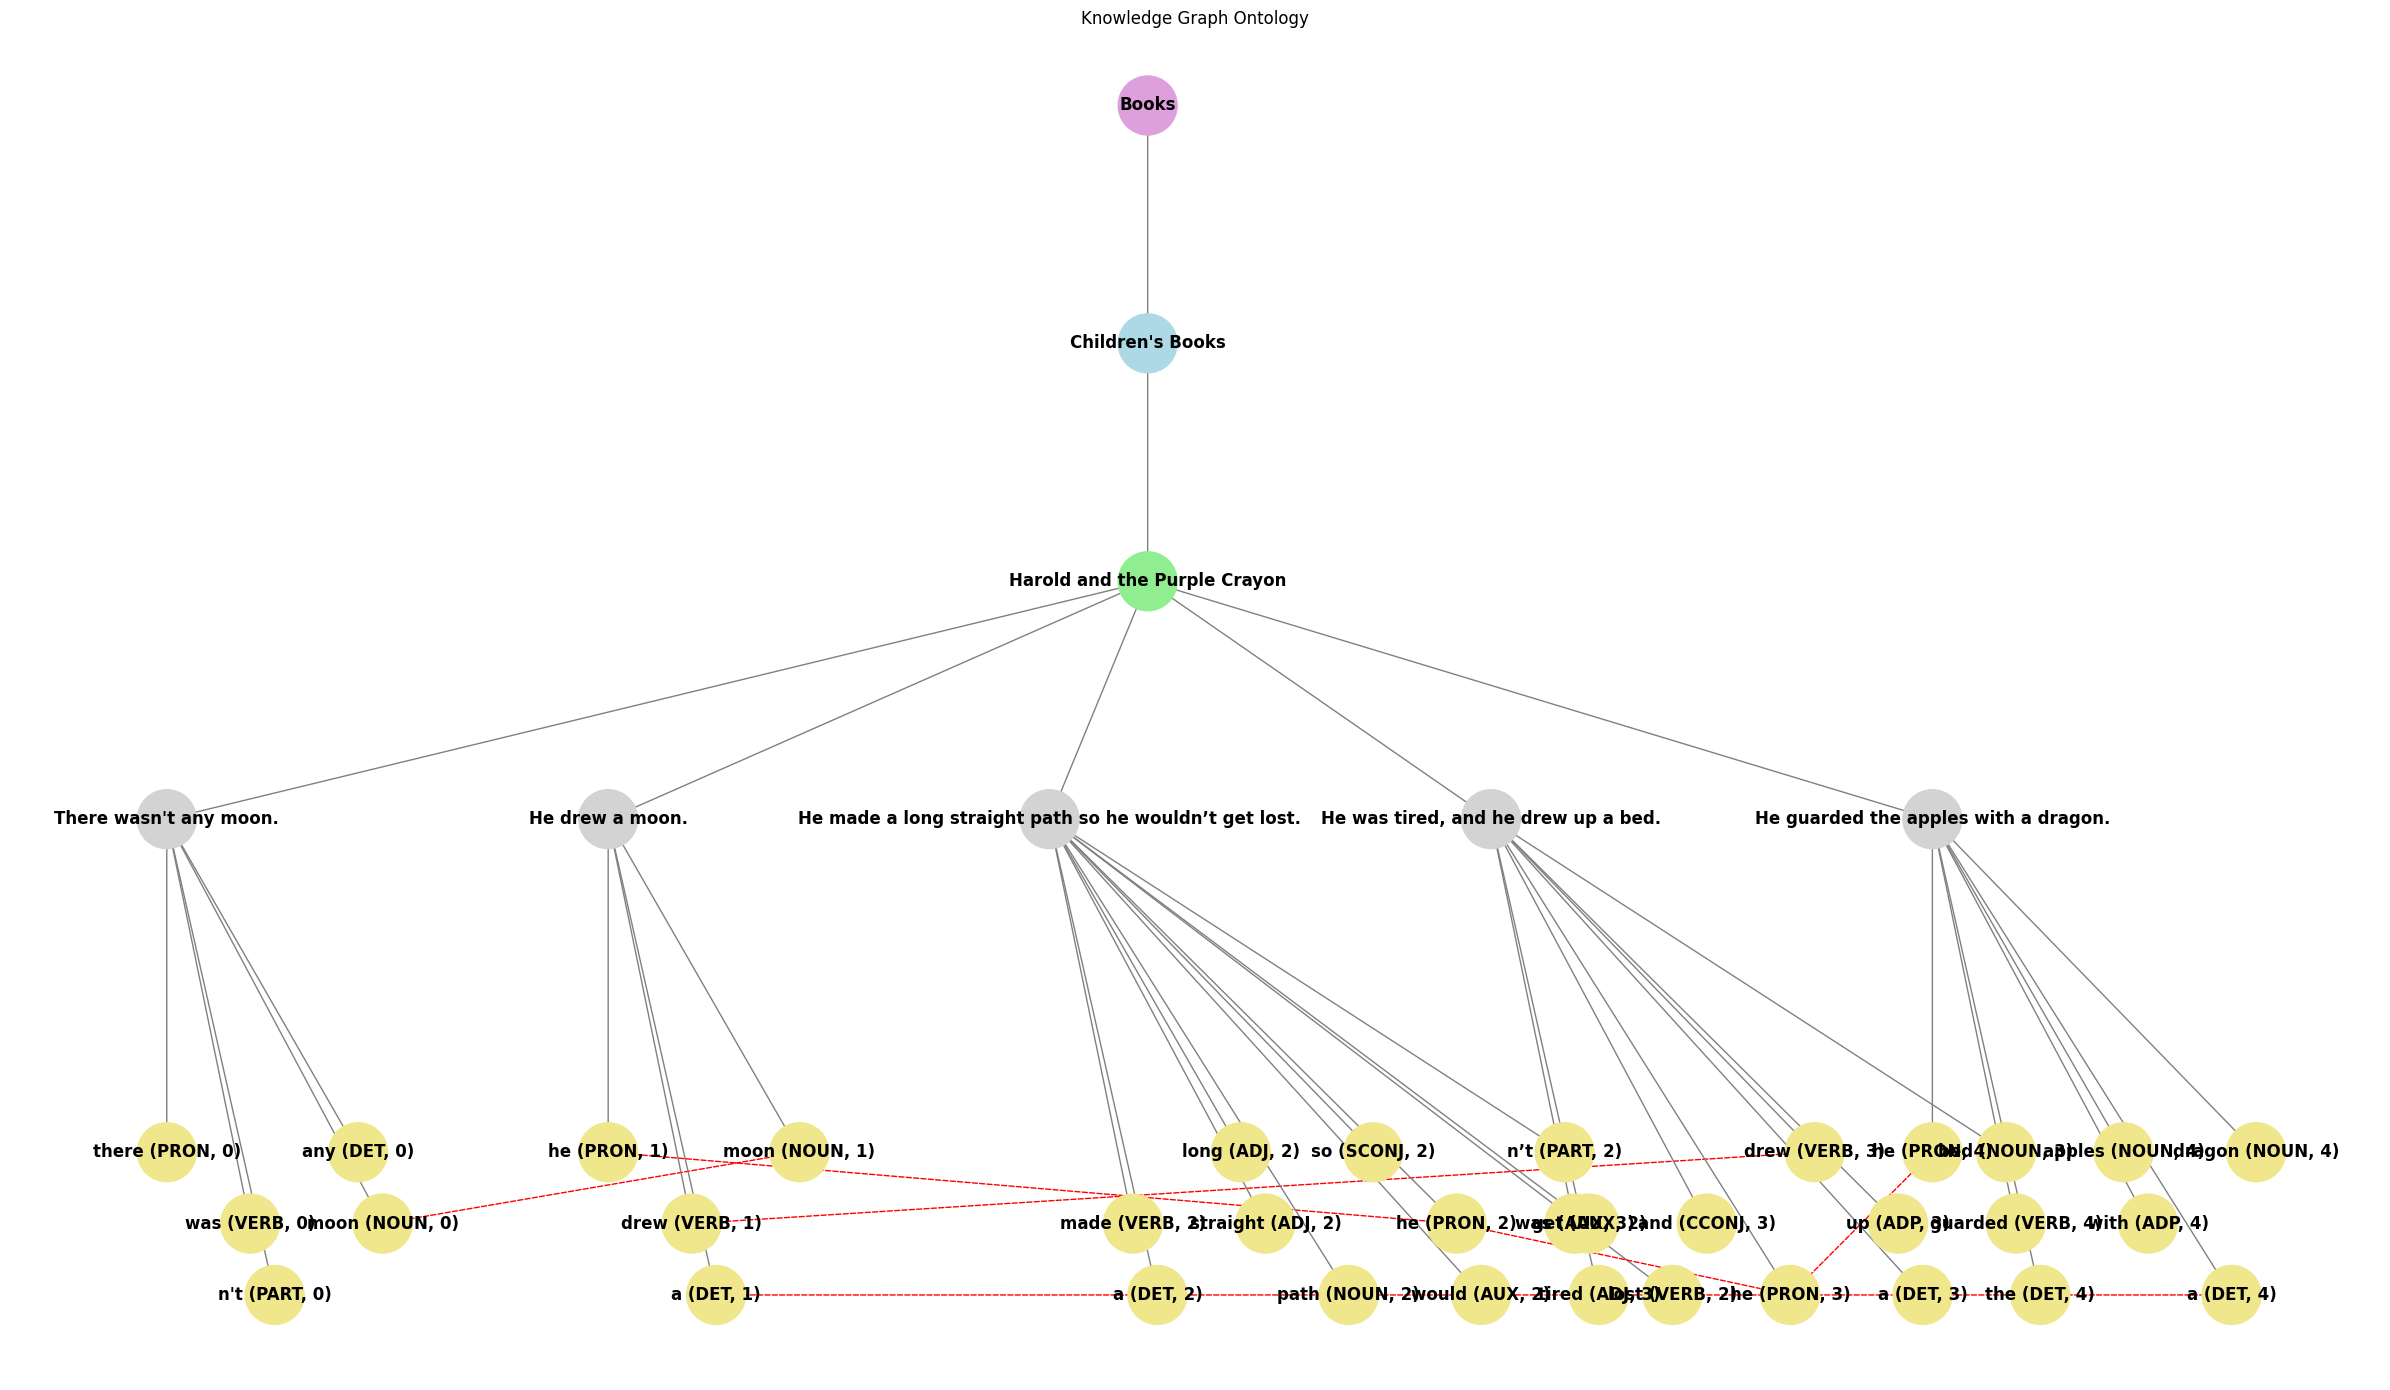

In [40]:
import networkx as nx
import matplotlib.pyplot as plt
import spacy

# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# Create the graph
G = nx.DiGraph()

# Root node
G.add_node("Books", type="root")

# Genre and title
genre = "Children's Books"
title = "Harold and the Purple Crayon"

G.add_node(genre, type="genre")
G.add_node(title, type="title")
G.add_edge("Books", genre)
G.add_edge(genre, title)

# Sentences from the book
sentences = [
    "There wasn't any moon.",
    "He drew a moon.",
    "He made a long straight path so he wouldn’t get lost.",
    "He was tired, and he drew up a bed.",
    "He guarded the apples with a dragon."
]

# Position dictionary and word memory
pos = {
    "Books": (0, 13),
    genre: (0, 11),
    title: (0, 9)
}
word_instances = {}

# Layout spacing
x_start = -20
sentence_spacing = 9

for i, sentence in enumerate(sentences):
    x_sent = x_start + i * sentence_spacing
    y_sent = 7
    sent_node = sentence  # No label prefix
    G.add_node(sent_node, type="sentence")
    G.add_edge(title, sent_node)
    pos[sent_node] = (x_sent, y_sent)

    doc = nlp(sentence)
    for j, token in enumerate(doc):
        if token.is_punct:
            continue
        word_label = f"{token.text.lower()} ({token.pos_}, {i})"

        # Positioning
        x_word = x_sent + j * 1.1 + (j % 2) * 0.6
        y_word = 4.2 - (j % 3) * 0.6

        G.add_node(word_label, type="word")
        G.add_edge(sent_node, word_label)
        pos[word_label] = (x_word, y_word)

        # Cross-sentence reference
        key = (token.text.lower(), token.pos_)
        if key in word_instances:
            G.add_edge(word_instances[key], word_label, type="reference")
        word_instances[key] = word_label

# Color nodes by type
node_colors = [
    'plum' if G.nodes[n]['type'] == 'root'
    else 'lightblue' if G.nodes[n]['type'] == 'genre'
    else 'lightgreen' if G.nodes[n]['type'] == 'title'
    else 'lightgray' if G.nodes[n]['type'] == 'sentence'
    else 'khaki'
    for n in G.nodes
]

# Style edges
edges = list(G.edges(data=True))
edge_colors = ['red' if d.get('type') == 'reference' else 'gray' for (_, _, d) in edges]
linestyles = ['dashed' if d.get('type') == 'reference' else 'solid' for (_, _, d) in edges]

# Draw graph
plt.figure(figsize=(24, 14))
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=1800)
nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold')

# Draw each edge individually for style control
for i, (u, v, data) in enumerate(edges):
    nx.draw_networkx_edges(
        G, pos, edgelist=[(u, v)],
        edge_color=edge_colors[i],
        style=linestyles[i],
        arrows=True
    )

plt.title("Knowledge Graph Ontology")
plt.axis('off')
plt.tight_layout()

# Save and display
plt.savefig('ontology.png')
plt.show()


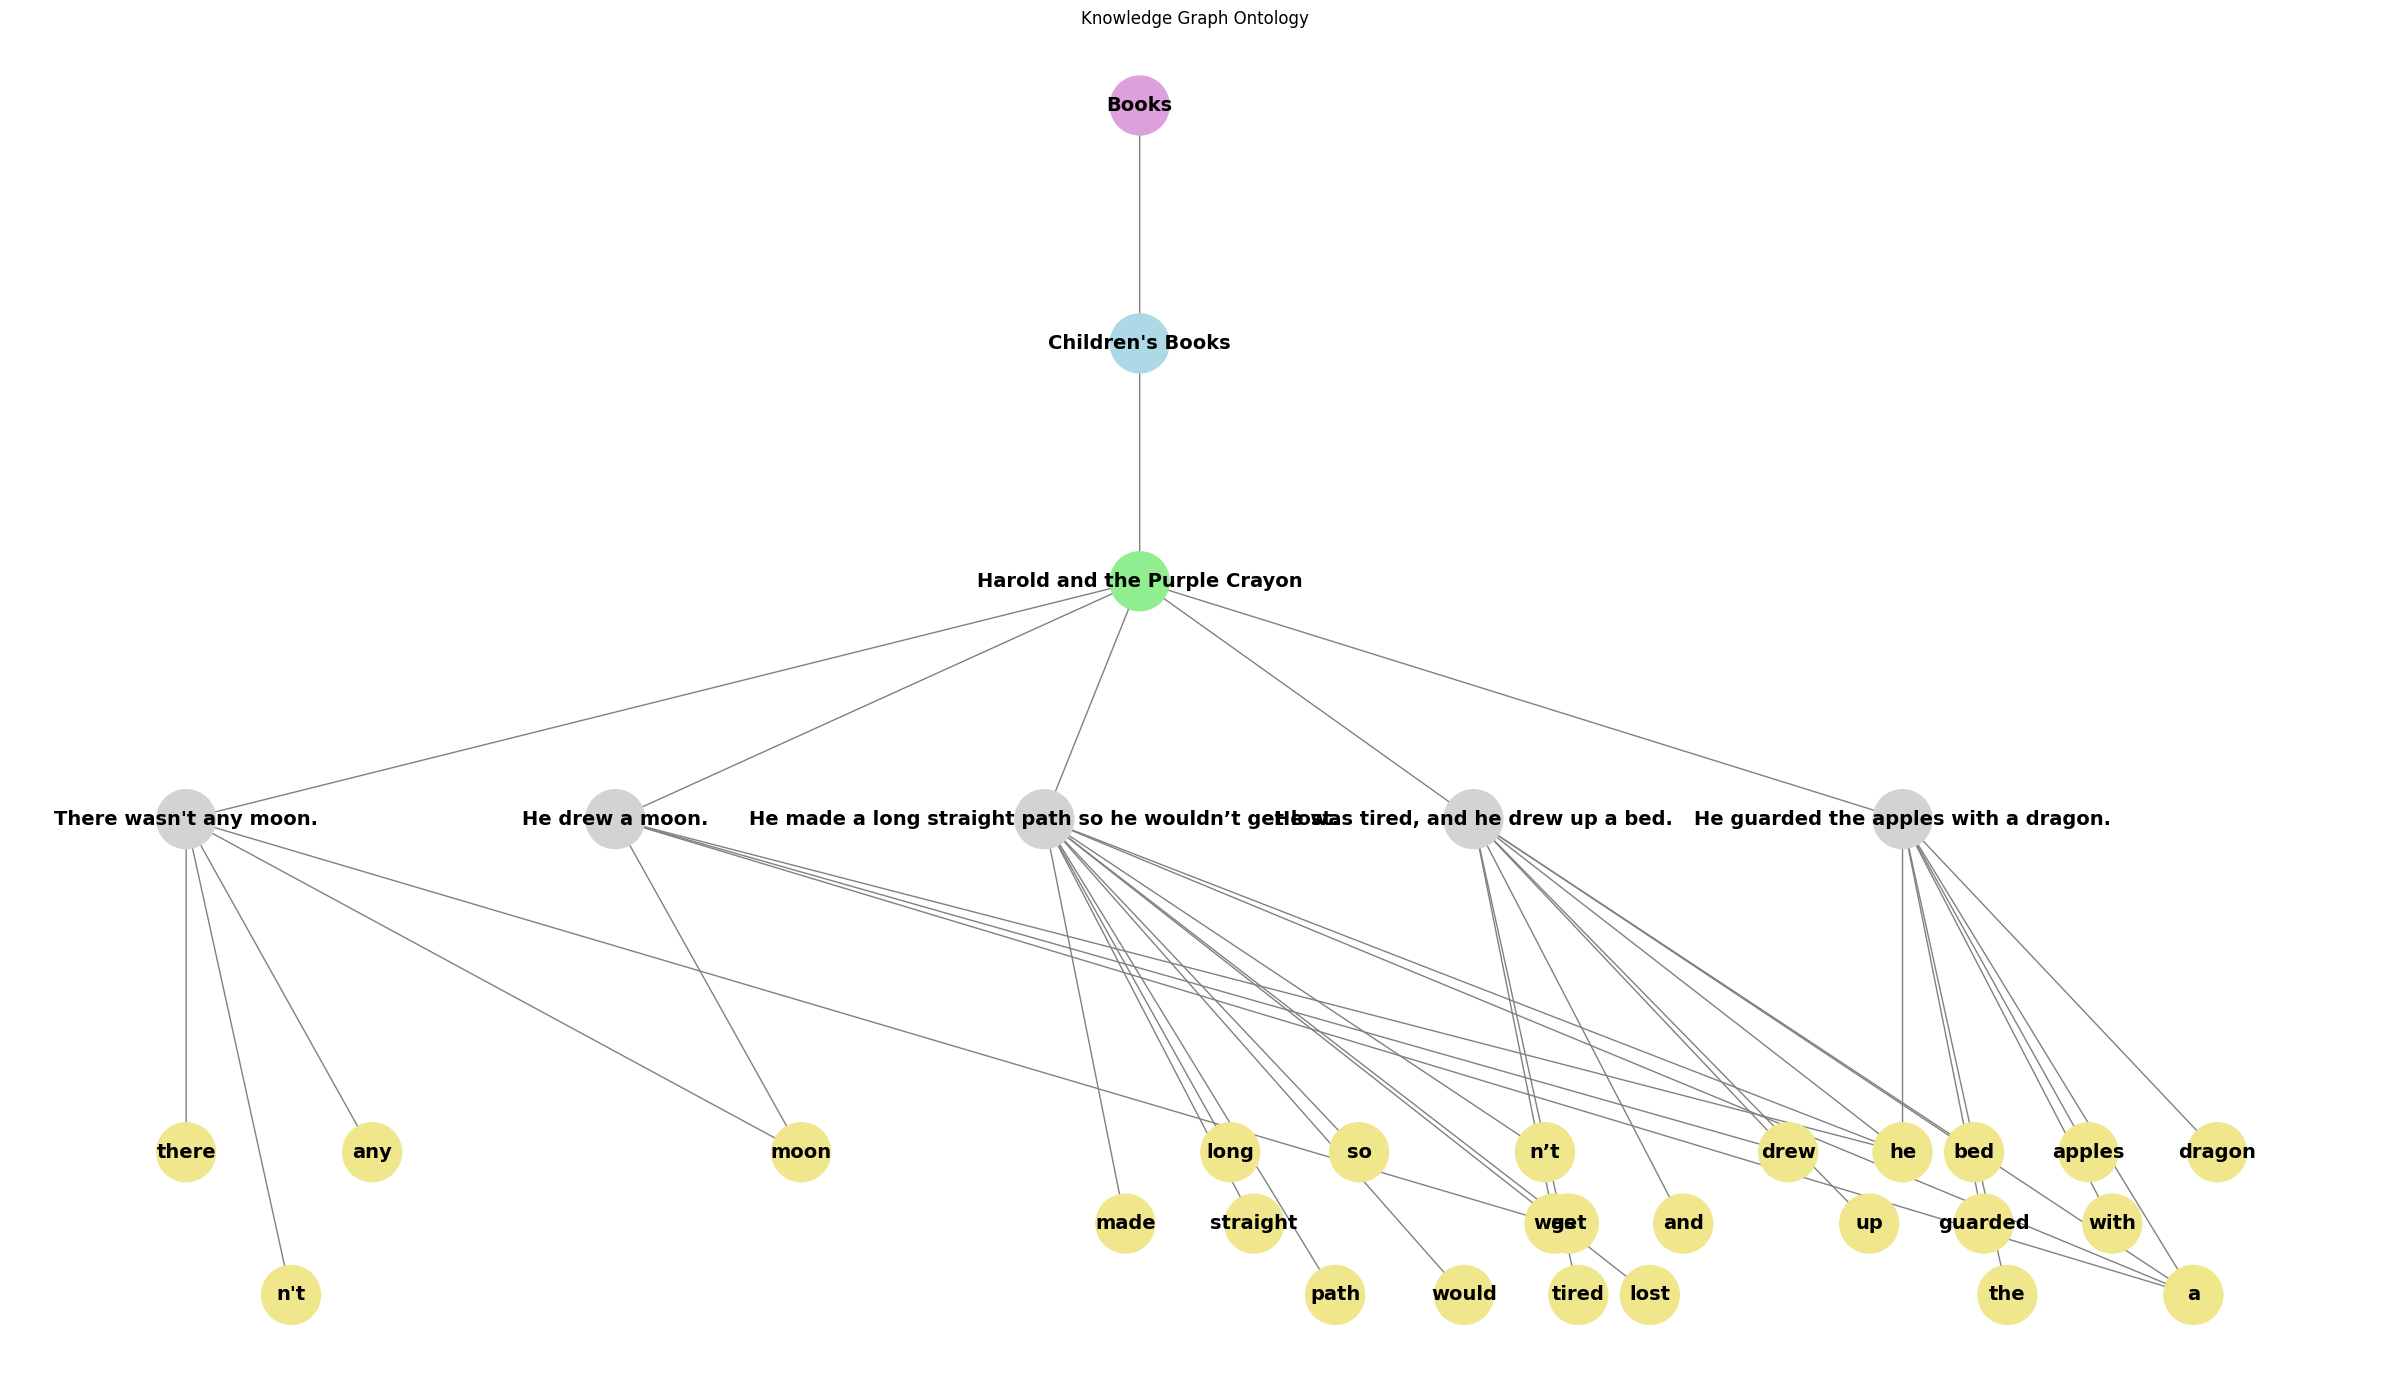

In [46]:
import networkx as nx
import matplotlib.pyplot as plt
import spacy

# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# Create the graph
G = nx.DiGraph()

# Root node
G.add_node("Books", type="root")

# Genre and title
genre = "Children's Books"
title = "Harold and the Purple Crayon"

G.add_node(genre, type="genre")
G.add_node(title, type="title")
G.add_edge("Books", genre)
G.add_edge(genre, title)

# Sentences from the book
sentences = [
    "There wasn't any moon.",
    "He drew a moon.",
    "He made a long straight path so he wouldn’t get lost.",
    "He was tired, and he drew up a bed.",
    "He guarded the apples with a dragon."
]

# Position dictionary and word memory
pos = {
    "Books": (0, 13),
    genre: (0, 11),
    title: (0, 9)
}
word_instances = {}

# Layout spacing
x_start = -20
sentence_spacing = 9

for i, sentence in enumerate(sentences):
    x_sent = x_start + i * sentence_spacing
    y_sent = 7
    sent_node = sentence  # No prefix label
    G.add_node(sent_node, type="sentence")
    G.add_edge(title, sent_node)
    pos[sent_node] = (x_sent, y_sent)

    doc = nlp(sentence)
    for j, token in enumerate(doc):
        if token.is_punct:
            continue
        word_label = token.text.lower()  # No POS tag

        x_word = x_sent + j * 1.1 + (j % 2) * 0.6
        y_word = 4.2 - (j % 3) * 0.6

        G.add_node(word_label, type="word")
        G.add_edge(sent_node, word_label)
        pos[word_label] = (x_word, y_word)

        key = word_label
        if key in word_instances:
            G.add_edge(word_instances[key], word_label, type="reference")
        word_instances[key] = word_label

# Color nodes
node_colors = [
    'plum' if G.nodes[n]['type'] == 'root'
    else 'lightblue' if G.nodes[n]['type'] == 'genre'
    else 'lightgreen' if G.nodes[n]['type'] == 'title'
    else 'lightgray' if G.nodes[n]['type'] == 'sentence'
    else 'khaki'
    for n in G.nodes
]

# Edge styles
edges = list(G.edges(data=True))
edge_colors = ['red' if d.get('type') == 'reference' else 'gray' for (_, _, d) in edges]
linestyles = ['dashed' if d.get('type') == 'reference' else 'solid' for (_, _, d) in edges]

# Draw graph
plt.figure(figsize=(24, 14))
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=1800)
nx.draw_networkx_labels(G, pos, font_size=14, font_weight='bold')

# Draw each edge with style
for i, (u, v, data) in enumerate(edges):
    nx.draw_networkx_edges(
        G, pos, edgelist=[(u, v)],
        edge_color=edge_colors[i],
        style=linestyles[i],
        arrows=True
    )

plt.title("Knowledge Graph Ontology")
plt.axis('off')
plt.tight_layout()

# Save and display
plt.savefig('ontology.png')
plt.show()


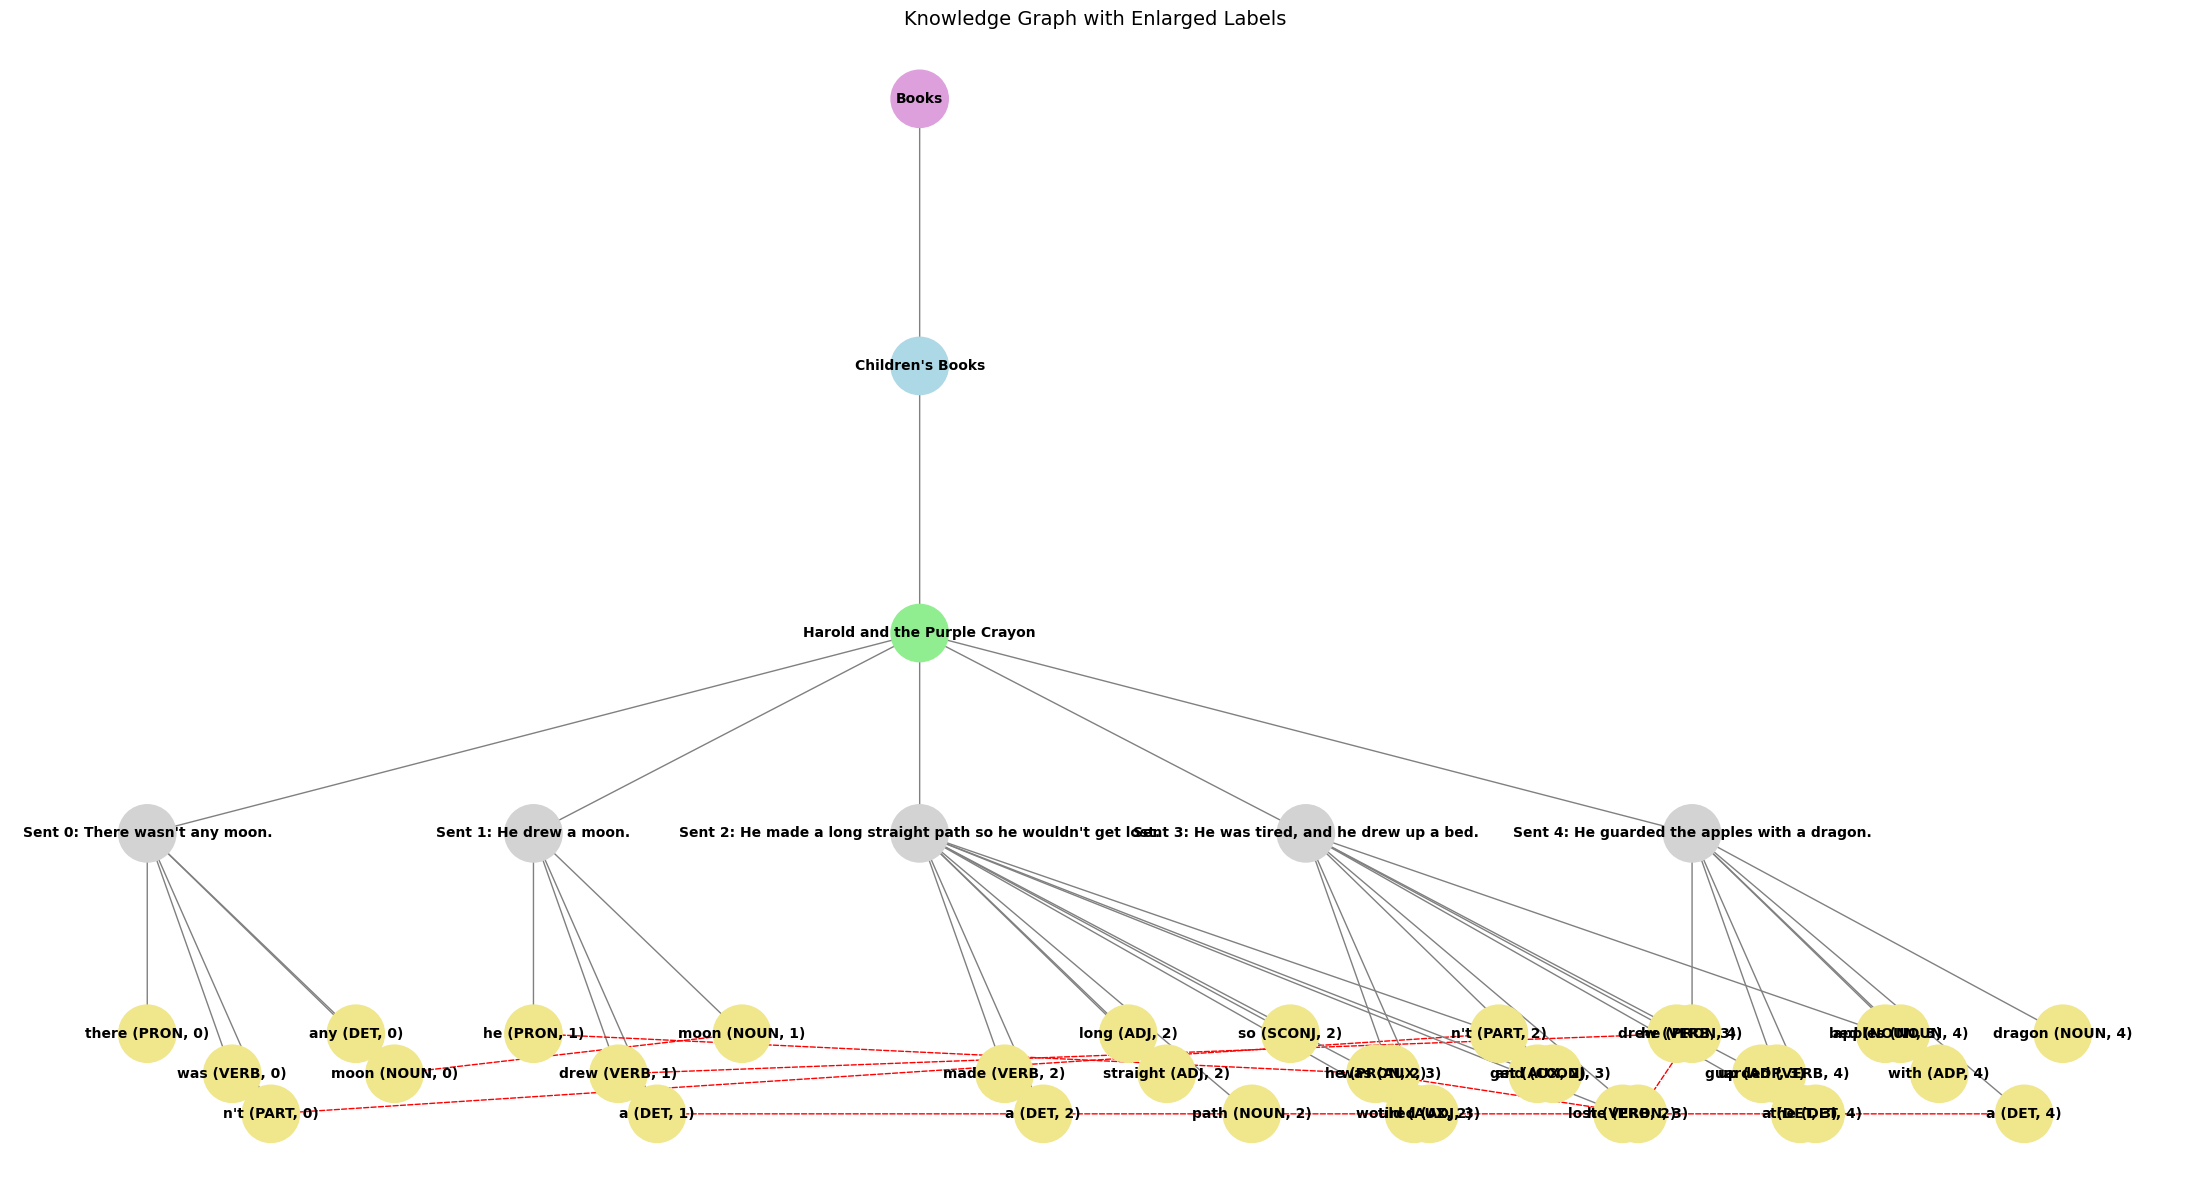

In [43]:
import networkx as nx
import matplotlib.pyplot as plt
import spacy

# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# Create the graph
G = nx.DiGraph()

# Root, genre, and title
G.add_node("Books", type="root")
G.add_node("Children's Books", type="genre")
G.add_node("Harold and the Purple Crayon", type="title")
G.add_edge("Books", "Children's Books")
G.add_edge("Children's Books", "Harold and the Purple Crayon")

# Sentences
sentences = [
    "There wasn't any moon.",
    "He drew a moon.",
    "He made a long straight path so he wouldn't get lost.",
    "He was tired, and he drew up a bed.",
    "He guarded the apples with a dragon."
]

# Position dict and reference tracker
pos = {
    "Books": (0, 10),
    "Children's Books": (0, 8),
    "Harold and the Purple Crayon": (0, 6)
}
word_instances = {}

# Compact layout parameters
x_start = -10
sentence_spacing = 5
word_spacing = 0.8
word_jitter_x = 0.3
word_jitter_y = 0.3

for i, sentence in enumerate(sentences):
    x_sent = x_start + i * sentence_spacing
    y_sent = 4.5
    sent_node = f"Sent {i}: {sentence}"
    G.add_node(sent_node, type="sentence")
    G.add_edge("Harold and the Purple Crayon", sent_node)
    pos[sent_node] = (x_sent, y_sent)

    doc = nlp(sentence)
    for j, token in enumerate(doc):
        if token.is_punct:
            continue
        word_label = f"{token.text.lower()} ({token.pos_}, {i})"
        x_word = x_sent + j * word_spacing + (j % 2) * word_jitter_x
        y_word = 3 - (j % 3) * word_jitter_y

        G.add_node(word_label, type="word")
        G.add_edge(sent_node, word_label)
        pos[word_label] = (x_word, y_word)

        key = (token.text.lower(), token.pos_)
        if key in word_instances:
            G.add_edge(word_instances[key], word_label, type="reference")
        word_instances[key] = word_label

# Color nodes
node_colors = [
    'plum' if G.nodes[n]['type'] == 'root'
    else 'lightblue' if G.nodes[n]['type'] == 'genre'
    else 'lightgreen' if G.nodes[n]['type'] == 'title'
    else 'lightgray' if G.nodes[n]['type'] == 'sentence'
    else 'khaki'
    for n in G.nodes
]

# Edge styles
edges = list(G.edges(data=True))
edge_colors = ['red' if d.get('type') == 'reference' else 'gray' for (_, _, d) in edges]
linestyles = ['dashed' if d.get('type') == 'reference' else 'solid' for (_, _, d) in edges]

# Draw graph with larger labels
plt.figure(figsize=(22, 12))
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=1700)
nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')  # ← Larger font size

for i, (u, v, data) in enumerate(edges):
    nx.draw_networkx_edges(
        G, pos, edgelist=[(u, v)],
        edge_color=edge_colors[i],
        style=linestyles[i],
        arrows=True
    )

plt.title("Knowledge Graph with Enlarged Labels", fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.show()


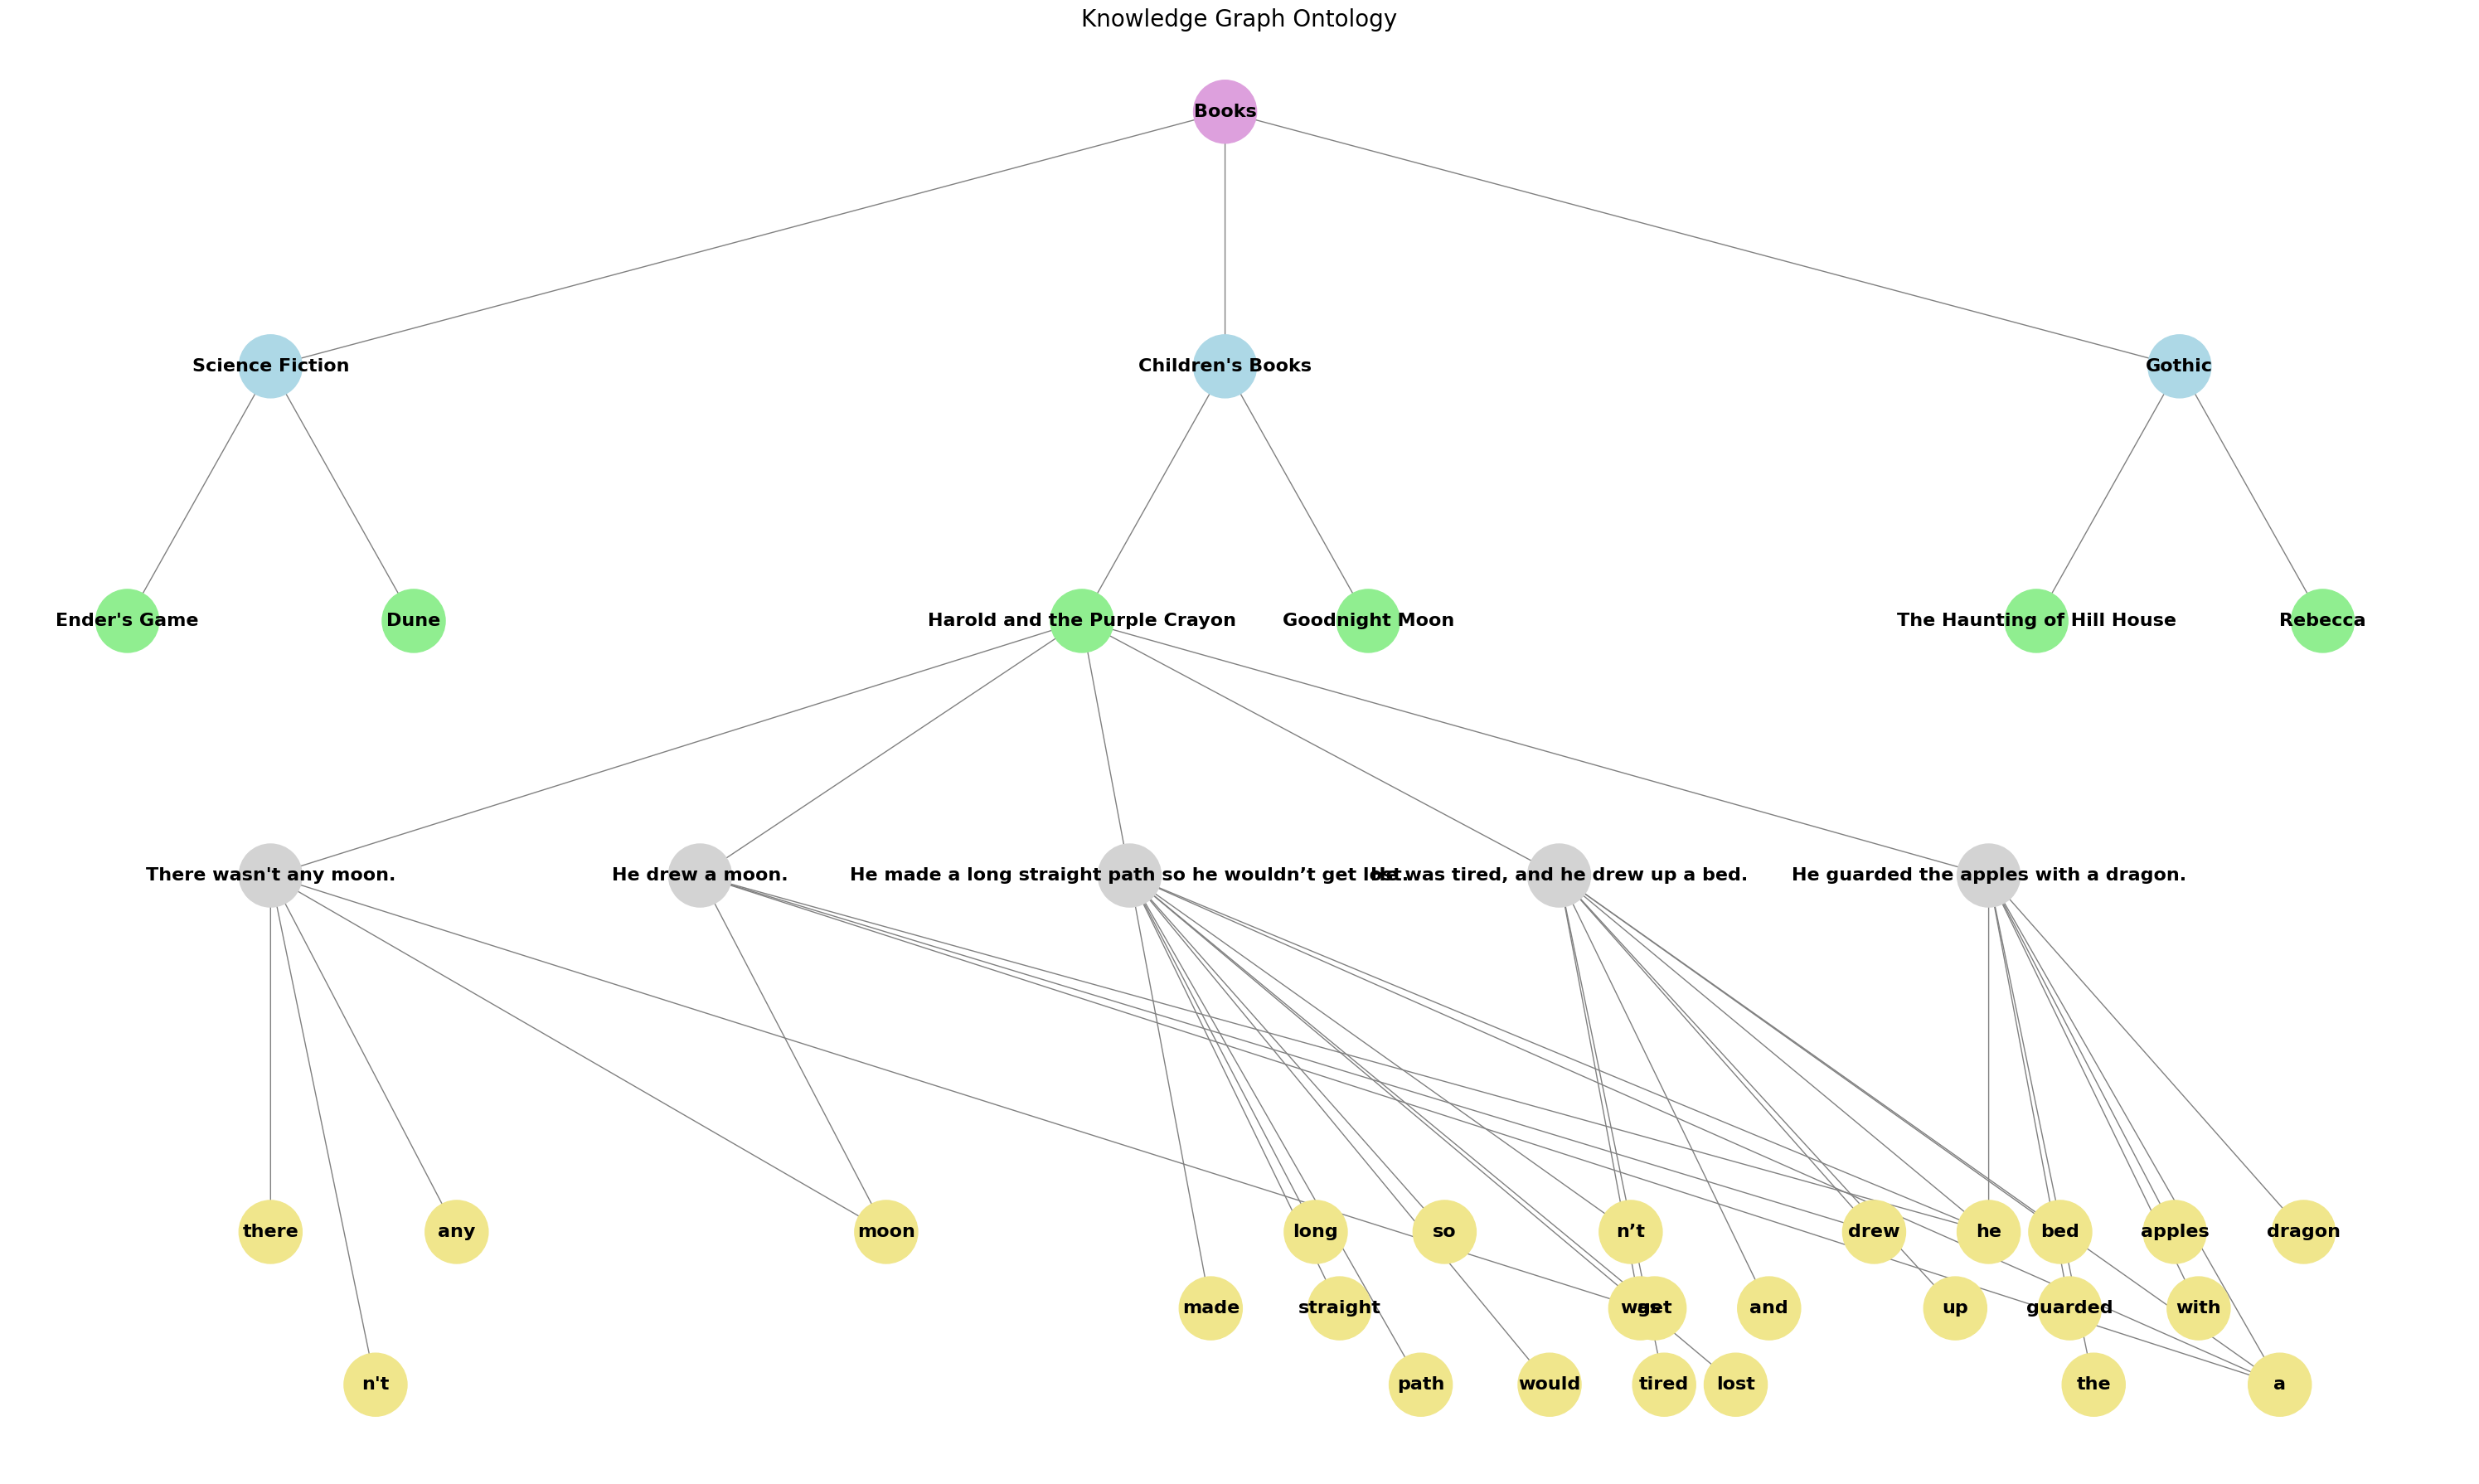

In [297]:
import networkx as nx
import matplotlib.pyplot as plt
import spacy

# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# Create the graph
G = nx.DiGraph()

# Root node
G.add_node("Books", type="root")

# Define genres and their titles
genres_titles = {
    "Science Fiction": [
        "Ender's Game",
        "Dune"
    ],
    "Children's Books": [
        "Harold and the Purple Crayon",
        "Goodnight Moon"
    ],
    "Gothic": [
        "The Haunting of Hill House",
        "Rebecca"
    ]
}

# Build genre and title hierarchy
for genre, titles in genres_titles.items():
    G.add_node(genre, type="genre")
    G.add_edge("Books", genre)
    for title in titles:
        G.add_node(title, type="title")
        G.add_edge(genre, title)

# Only break down Harold and the Purple Crayon
harold_title = "Harold and the Purple Crayon"
sentences = [
    "There wasn't any moon.",
    "He drew a moon.",
    "He made a long straight path so he wouldn’t get lost.",
    "He was tired, and he drew up a bed.",
    "He guarded the apples with a dragon."
]

# Position dictionary and word memory
pos = {
    "Books": (0, 13)
}
word_instances = {}

# Recenter the layout: put "Children's Books" at x=0
genre_order = ["Science Fiction", "Children's Books", "Gothic"]
genre_positions = {
    "Science Fiction": -20,
    "Children's Books": 0,
    "Gothic": 20
}
genre_y = 11
title_y = 9
title_spacing = 6

for genre in genre_order:
    gx = genre_positions[genre]
    pos[genre] = (gx, genre_y)
    titles = genres_titles[genre]
    for j, title in enumerate(titles):
        tx = gx + (j - (len(titles) - 1) / 2) * title_spacing
        pos[title] = (tx, title_y)

# Sentence and word layout for Harold
x_start = -20
sentence_spacing = 9
for i, sentence in enumerate(sentences):
    x_sent = x_start + i * sentence_spacing
    y_sent = 7
    sent_node = sentence
    G.add_node(sent_node, type="sentence")
    G.add_edge(harold_title, sent_node)
    pos[sent_node] = (x_sent, y_sent)

    doc = nlp(sentence)
    for j, token in enumerate(doc):
        if token.is_punct:
            continue
        word_label = token.text.lower()

        x_word = x_sent + j * 1.1 + (j % 2) * 0.6
        y_word = 4.2 - (j % 3) * 0.6

        G.add_node(word_label, type="word")
        G.add_edge(sent_node, word_label)
        pos[word_label] = (x_word, y_word)

        key = word_label
        if key in word_instances:
            G.add_edge(word_instances[key], word_label, type="reference")
        word_instances[key] = word_label

# Color nodes
node_colors = [
    'plum' if G.nodes[n]['type'] == 'root'
    else 'lightblue' if G.nodes[n]['type'] == 'genre'
    else 'lightgreen' if G.nodes[n]['type'] == 'title'
    else 'lightgray' if G.nodes[n]['type'] == 'sentence'
    else 'khaki'
    for n in G.nodes
]

# Edge styles
edges = list(G.edges(data=True))
edge_colors = ['red' if d.get('type') == 'reference' else 'gray' for (_, _, d) in edges]
linestyles = ['dashed' if d.get('type') == 'reference' else 'solid' for (_, _, d) in edges]

# Draw graph
plt.figure(figsize=(30, 18))
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=3000)
nx.draw_networkx_labels(G, pos, font_size=16, font_weight='bold')

for i, (u, v, data) in enumerate(edges):
    nx.draw_networkx_edges(
        G, pos, edgelist=[(u, v)],
        edge_color=edge_colors[i],
        style=linestyles[i],
        arrows=True
    )

plt.title("Knowledge Graph Ontology", fontsize=20)
plt.axis('off')
plt.tight_layout()

# Save and display
plt.savefig('ontology_expanded.png')
plt.show()


In [ ]:
#def build_knowledge_graph(triples):
#    """
#    Build a directed graph where nodes are entities and edges are predicates.
#    Returns a NetworkX DiGraph.
#    """
#    G = nx.DiGraph()
#    for subj, pred, obj in triples:
#        G.add_node(subj)
#        G.add_node(obj)
#        G.add_edge(subj, obj, label=pred)
#    return G


#def extract_triples(text):
#    """
#    Use spaCy to extract subject-predicate-object triples from text.
#    """
#    triples = []
#    doc = nlp(text)
#    for sent in doc.sents:
#        subject = None
#        predicate = None
#        obj = None
#        for token in sent:
#            if "subj" in token.dep_:
#                subject = token.text
#                predicate = token.head.text
#                for child in token.head.children:
#                    if "obj" in child.dep_:
#                        obj = child.text
#                        triples.append((subject, predicate, obj))
#    return triples

#def extract_triples(text):
#    """
#    Use spaCy to extract subject-predicate-object triples from text.
#    Also handles fragmentary phrases like 'dragon under tree'.
#    """
#    triples = []
#    doc = nlp(text)
#    for sent in doc.sents:
#        subject = None
#        predicate = None
#        obj = None

        # First try to extract standard subject-verb-object pattern
#        for token in sent:
#            if "subj" in token.dep_:
#                subject = token.text
#                predicate = token.head.text
#                for child in token.head.children:
#                    if "obj" in child.dep_:
#                        obj = child.text
#                        triples.append((subject, predicate, obj))

        # If no triple found, try to extract noun-preposition-noun
#        if not triples:
#            for token in sent:
#                if token.pos_ == "NOUN":
#                    for child in token.children:
#                        if child.dep_ == "prep":
#                            for obj_candidate in child.children:
#                                if obj_candidate.pos_ == "NOUN":
#                                    subject = token.text
#                                    predicate = child.text
#                                    obj = obj_candidate.text
#                                    triples.append((subject, predicate, obj))
#    return triples


In [ ]:
def extract_triples(sentence):
    """
    Convert ask_groq's string output to a list of (subject, predicate, object) tuples.
    """
    groq_output = ask_groq(f"""
        Return just the subject, verb, object 
        and object, predicate, object triples from this sentence:  
        {sentence}
        Return the output like this (word, word, word)
    """)
    
    # Use regex to find all patterns like (word, word, word)
    triple_pattern = re.findall(r'\(([^)]+)\)', groq_output)
    
    triples = []
    for triple in triple_pattern:
        parts = [part.strip() for part in triple.split(',')]
        if len(parts) == 3:
            triples.append((parts[0], parts[1], parts[2]))
    return triples

def build_knowledge_graph(triples, sentences):
    """
    Build a directed graph where each node is a dictionary with a 'text' key storing associated sentences.
    """
    graph = defaultdict(list)
    node_data = defaultdict(set)  # Map entity to set of sentences

    for sentence in sentences:
        sentence = sentence.lower()
        sentence_triples = extract_triples(sentence)
        for subj, pred, obj in sentence_triples:
            graph[subj].append((obj, pred))
            node_data[subj].add(sentence)
            node_data[obj].add(sentence)

    # Convert sets to plain dicts with text list
    node_metadata = {k: {'text': list(v)} for k, v in node_data.items()}
    return graph, node_metadata

def dfs_until_match(graph, node_metadata, start, query, visited=None, path=None, edges=None):
    if visited is None:
        visited = set()
    if path is None:
        path = []
    if edges is None:
        edges = []

    visited.add(start)
    path = path + [start]  # Avoid mutability issues

    response = ask_groq(f"{query} {start}")
    print(f"Checking node: {start} → Response: {response.strip().lower()}")

    if response.strip().lower() == 'yes':
        return path, edges, True

    for neighbor, relation in graph.get(start, []):
        if neighbor not in visited:
            new_edges = edges + [(start, relation, neighbor)]
            result_path, result_edges, found = dfs_until_match(
                graph, node_metadata, neighbor, query, visited, path, new_edges
            )
            if found:
                return result_path, result_edges, True
    return path, edges, False

all_sentences = [s.lower() for s in text]

graph, node_metadata = build_knowledge_graph([], all_sentences)

print("Knowledge Graph:")
for subj in graph:
    for obj, pred in graph[subj]:
        print(f"{subj} -[{pred}]-> {obj}")

query = 'is the name dave? Reply just YES or NO. This is the name: '

print("\nDFS Until Match starting from carol:")

path, edges, found = dfs_until_match(graph, node_metadata, "carol", query)

print("\nDFS Path:", " -> ".join(path))
print("Edges Traversed:")
for subj, pred, obj in edges:
    print(f"{subj} -[{pred}]-> {obj}")

print("\nNode Metadata (Context Sentences):")
for node, meta in node_metadata.items():
    print(f"{node}: {meta['text']}")

NetworkXError: Node 'harold' has no position.

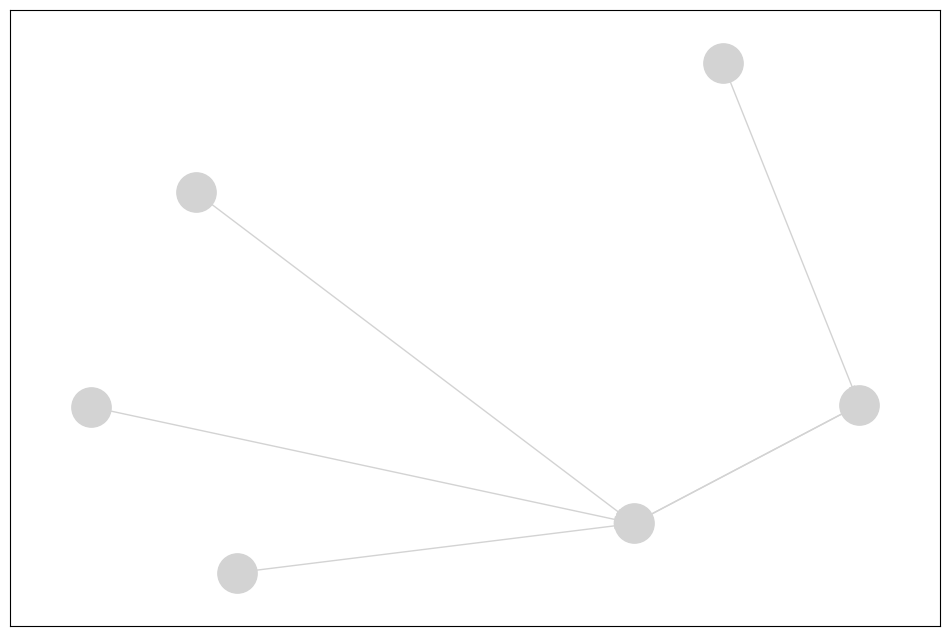

In [204]:
import networkx as nx
import matplotlib.pyplot as plt

def visualize_dfs_path(graph_dict, path, edges, title="DFS Traversal Visualization"):
    """
    Visualizes the traversal path and edges in a directed graph.

    Parameters:
        graph_dict (dict): The original graph structure as an adjacency list.
        path (list): The list of nodes visited in the order they were traversed.
        edges (list): The list of (subject, predicate, object) tuples in the traversal.
        title (str): Title of the plot.
    """
    G = nx.DiGraph()

    # Add all nodes and edges from the original graph for context (optional)
    for subj, relations in graph_dict.items():
        for obj, pred in relations:
            G.add_edge(subj, obj, label=pred)

    # Highlighted edges are the ones traversed
    edge_labels = {(s, o): p for s, p, o in edges}

    pos = nx.spring_layout(G, seed=42)

    plt.figure(figsize=(12, 8))
    nx.draw_networkx_nodes(G, pos, node_color='lightgray', node_size=800)
    nx.draw_networkx_edges(G, pos, edge_color='lightgray')

    # Draw only traversed path in bold
    nx.draw_networkx_edges(
        G,
        pos,
        edgelist=[(s, o) for s, _, o in edges],
        edge_color='blue',
        width=2
    )

    # Draw path nodes in a different color
    nx.draw_networkx_nodes(
        G,
        pos,
        nodelist=path,
        node_color='orange',
        node_size=1000
    )

    nx.draw_networkx_labels(G, pos, font_size=10, font_color='black')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=9)

    plt.title(title)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig("test.png")
    plt.show()

visualize_dfs_path(graph, path, edges)